Systematic Framework

In [1]:
# import sys
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import HTML 
# import warnings
# # Path to scripts on KEKCC
# sys_path = '/group/belle2/dataprod/Systematics/systematic_corrections_framework/scripts'
# # for NAF: 
# # sys_path = '/nfs/dust/belle2/group/dataprod/Systematics/systematic_corrections_framework/scripts'
# sys.path.insert(1, sys_path)

# import weight_table as wm
# from show_db_content import show_db_content
# from show_variables import show_ntuple_variables
# import show_collections as sc
# import sysvar

In [2]:
import seaborn as sns

import hep_ml
from hep_ml import reweight
import numpy as np
import pandas as pd
import uproot
from matplotlib import pyplot as plt

In [3]:
plt.rcParams.update({
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 16,
    "figure.titlesize": 20
})

In [4]:
pd.set_option('display.max_rows', 200000)
pd.set_option('display.max_columns', 200000)

In [5]:
import sys
sys.path.append("/home/belle2/amubarak/Ds2D0enue_Analysis/07-Python_Functions/")

from plotting_utils_pidopt import optimize_cut, plot_roc_curve

# Prep-Work

### Import Data

Correct Charge

In [6]:
import os
import uproot
import pandas as pd
from tqdm import tqdm

# === Load only selected branches ===
with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
    variables_to_load = [
        line.strip().strip(",").strip('"').strip("'")
        for line in f
        if line.strip() and not line.strip().startswith("#")
    ]

# Ensure BDT variable is included
if "Ds_FakeD0BDT" not in variables_to_load:
    variables_to_load.append("Ds_FakeD0BDT")

# Make sure Ds_BkgBDT is included
if "Ds_BkgBDT" not in variables_to_load:
    variables_to_load.append("Ds_BkgBDT")

# === Sample list ===
samples = ["Signal", "BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
GenEvents = samples.copy()

# === Input configuration for BkgBDT ===
Date = "0530"
Attempt = "0"
input_dir = "/group/belle/users/amubarak/03-ML/BkgBDT/"

# === Load ROOT files into DataFrames ===
DataFrames = {}

for s in tqdm(samples, desc="Loading ROOT files"):
    if s == "Signal":
        file_path = os.path.join(input_dir, "Ds2D0enu-Signal_withBkgBDT.root")
    else:
        file_path = os.path.join(
            input_dir, f"Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{s}_withBkgBDT.root"
        )

    df = uproot.concatenate(
        f"{file_path}:Dstree",
        filter_name=variables_to_load,
        library="pd"
    )

    print(f"✔️ Loaded {file_path} with {len(df):,} entries")
    DataFrames[s] = df

# === Define combined background ===
background_samples = ["BB", "ccbar", "ddbar", "ssbar", "taupair", "uubar"]
DataFrames["All"] = pd.concat([DataFrames[s] for s in background_samples], ignore_index=True)

# === Combine uds backgrounds for convenience ===
DataFrames["uds"] = pd.concat(
    [DataFrames["uubar"], DataFrames["ddbar"], DataFrames["ssbar"]],
    ignore_index=True
)

Loading ROOT files:  14%|█▍        | 1/7 [00:02<00:15,  2.63s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0enu-Signal_withBkgBDT.root with 178,170 entries


Loading ROOT files:  29%|██▊       | 2/7 [00:03<00:06,  1.33s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_BB_withBkgBDT.root with 13,631 entries


Loading ROOT files:  43%|████▎     | 3/7 [00:16<00:27,  6.80s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_ccbar_withBkgBDT.root with 1,175,804 entries


Loading ROOT files:  57%|█████▋    | 4/7 [00:16<00:13,  4.36s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_ddbar_withBkgBDT.root with 21,553 entries


Loading ROOT files:  71%|███████▏  | 5/7 [00:17<00:06,  3.06s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_ssbar_withBkgBDT.root with 41,512 entries


Loading ROOT files:  86%|████████▌ | 6/7 [00:18<00:02,  2.12s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_taupair_withBkgBDT.root with 1,518 entries


Loading ROOT files: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT/Ds2D0e-Generic_Ds_053025_0_uubar_withBkgBDT.root with 95,445 entries


Reversed PID

In [7]:
import os
import uproot
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Load only selected branches ===
with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
    variables_to_load = [
        line.strip().strip(",").strip('"').strip("'")
        for line in f
        if line.strip() and not line.strip().startswith("#")
    ]

# Ensure critical vars included
for var in ["Ds_FakeD0BDT", "Ds_BkgBDT"]:
    if var not in variables_to_load:
        variables_to_load.append(var)

# === Ask user if they want to load every 4th entry
skip_by_4 = input("Load only every 4th entry of control sample? (y/n): ").strip().lower() == "y"

# === ReverseID sample list ===
samples_ReverseID = [
    "Signal_ReverseID", "BB_ReverseID", "ccbar_ReverseID",
    "ddbar_ReverseID", "ssbar_ReverseID", "taupair_ReverseID",
    "uubar_ReverseID", "Data_ReverseID"
]

# === Input configuration ===
Date = "0626"
Attempt = "0"
input_dir = "/group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/"

# === Load ROOT files into DataFrames ===
for s in tqdm(samples_ReverseID, desc="Loading ReverseID"):
    if s == "Signal_ReverseID":
        file_path = os.path.join(input_dir, "Ds2D0enu-Signal_ReverseID_withBkgBDT.root")
    else:
        tag = s.replace("_ReverseID", "")
        file_path = os.path.join(
            input_dir, f"Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{tag}_withBkgBDT.root"
        )

    # Load full tree first
    df = uproot.concatenate(
        f"{file_path}:Dstree",
        filter_name=variables_to_load,
        library="pd"
    )

    # Then skip every 4th entry if requested (not for signal)
    if skip_by_4 and s != "Signal_ReverseID":
        df = df.iloc[::4].reset_index(drop=True)

    print(f"✔️ Loaded {file_path} with {len(df):,} entries")
    DataFrames[s] = df

# === Combine reversed PID backgrounds
background_samples = [
    "BB_ReverseID", "ccbar_ReverseID", "ddbar_ReverseID",
    "ssbar_ReverseID", "taupair_ReverseID", "uubar_ReverseID"
]

DataFrames["All_ReverseID"] = pd.concat(
    [DataFrames[s] for s in background_samples],
    ignore_index=True
)

DataFrames["uds_ReverseID"] = pd.concat(
    [DataFrames["uubar_ReverseID"], DataFrames["ddbar_ReverseID"], DataFrames["ssbar_ReverseID"]],
    ignore_index=True
)

Loading ReverseID:  12%|█▎        | 1/8 [00:03<00:24,  3.46s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0enu-Signal_ReverseID_withBkgBDT.root with 292,139 entries


Loading ReverseID:  25%|██▌       | 2/8 [00:05<00:14,  2.34s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_BB_withBkgBDT.root with 115,681 entries


Loading ReverseID:  38%|███▊      | 3/8 [02:32<05:43, 68.79s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_ccbar_withBkgBDT.root with 13,496,870 entries


Loading ReverseID:  50%|█████     | 4/8 [02:35<02:50, 42.67s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_ddbar_withBkgBDT.root with 227,210 entries


Loading ReverseID:  62%|██████▎   | 5/8 [02:40<01:26, 28.99s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_ssbar_withBkgBDT.root with 433,554 entries


Loading ReverseID:  75%|███████▌  | 6/8 [02:40<00:38, 19.27s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_taupair_withBkgBDT.root with 11,008 entries


Loading ReverseID:  88%|████████▊ | 7/8 [02:51<00:16, 16.41s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_uubar_withBkgBDT.root with 978,547 entries


Loading ReverseID: 100%|██████████| 8/8 [03:21<00:00, 25.15s/it]

✔️ Loaded /group/belle/users/amubarak/03-ML/BkgBDT_ReverseID/Ds2D0e-Generic_Ds_062625_0_Data_withBkgBDT.root with 4,034,540 entries


Reversed PID and Wrong Charge

In [8]:
# import os
# import uproot
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# # === Load only selected branches ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/Save_var.txt") as f:
#     variables_to_load = [
#         line.strip().strip(",").strip('"').strip("'")
#         for line in f
#         if line.strip() and not line.strip().startswith("#")
#     ]

# # Ensure critical vars included
# for var in ["Ds_FakeD0BDT", "Ds_BkgBDT"]:
#     if var not in variables_to_load:
#         variables_to_load.append(var)

# # === Ask user if they want to load every 4th entry
# skip_by_4 = input("Load only every 4th entry of control sample? (y/n): ").strip().lower() == "y"

# # === ReverseID_WCh sample list ===
# samples_ReverseID_WCh = [
#     "BB_ReverseID_WCh", "ccbar_ReverseID_WCh",
#     "ddbar_ReverseID_WCh", "ssbar_ReverseID_WCh", "taupair_ReverseID_WCh",
#     "uubar_ReverseID_WCh", "Data_ReverseID_WCh"
# ]

# # === Input configuration ===
# Date = "0708"
# Attempt = "0"
# input_dir = "/group/belle/users/amubarak/03-ML/BkgBDT_ReverseID_WCh/"

# # === Load ROOT files into DataFrames ===
# for s in tqdm(samples_ReverseID_WCh, desc="Loading ReverseID_WCh"):
#     if s == "Signal_ReverseID_WCh":
#         file_path = os.path.join(input_dir, "Ds2D0enu-Signal_ReverseID_WCh_withBkgBDT.root")
#     else:
#         tag = s.replace("_ReverseID_WCh", "")
#         file_path = os.path.join(
#             input_dir, f"Ds2D0e-Generic_Ds_{Date}25_{Attempt}_{tag}_withBkgBDT.root"
#         )

#     # Load full tree first
#     df = uproot.concatenate(
#         f"{file_path}:Dstree",
#         filter_name=variables_to_load,
#         library="pd"
#     )

#     # Then skip every 4th entry if requested (not for signal)
#     if skip_by_4 and s != "Signal_ReverseID_WCh":
#         df = df.iloc[::4].reset_index(drop=True)

#     print(f"✔️ Loaded {file_path} with {len(df):,} entries")
#     DataFrames[s] = df

# # === Combine reversed PID backgrounds
# background_samples = [
#     "BB_ReverseID_WCh", "ccbar_ReverseID_WCh", "ddbar_ReverseID_WCh",
#     "ssbar_ReverseID_WCh", "taupair_ReverseID_WCh", "uubar_ReverseID_WCh"
# ]

# DataFrames["All_ReverseID_WCh"] = pd.concat(
#     [DataFrames[s] for s in background_samples],
#     ignore_index=True
# )

# DataFrames["uds_ReverseID_WCh"] = pd.concat(
#     [DataFrames["uubar_ReverseID_WCh"], DataFrames["ddbar_ReverseID_WCh"], DataFrames["ssbar_ReverseID_WCh"]],
#     ignore_index=True
# )

Simulation

In [9]:
# DataFrames["Dstarplus"] =  uproot.concatenate("/home/belle2/amubarak/C01-Simulated_Events/Dstarplus-Background.root",library='pd')

The line below is to look at the available variables.

In [10]:
print(DataFrames.keys())

dict_keys(['Signal', 'BB', 'ccbar', 'ddbar', 'ssbar', 'taupair', 'uubar', 'All', 'uds', 'Signal_ReverseID', 'BB_ReverseID', 'ccbar_ReverseID', 'ddbar_ReverseID', 'ssbar_ReverseID', 'taupair_ReverseID', 'uubar_ReverseID', 'Data_ReverseID', 'All_ReverseID', 'uds_ReverseID'])


In [ ]:
DataFrames["All_ReverseID"].columns.tolist()

In [ ]:
DataFrames["Signal"].columns.tolist()

## Setup

In [11]:
# BDT
#-------------------
for key in DataFrames.keys():
    DataFrames[key] = DataFrames[key].loc[DataFrames[key]["Ds_BkgBDT"] >= 0.86]
# for key in DataFrames.keys():
#     DataFrames[key] = DataFrames[key].loc[DataFrames[key]["Ds_BkgBDT"] >= 0.86]

# # Vertex Fit
# #----------------
# for key in DataFrames.keys():
#     DataFrames[key] = DataFrames[key].loc[DataFrames[key]["Ds_chiProb_Ds_rank"] == 1]

# Photon Conversion
#-------------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_gammaveto_M_Correction']>=0.1]
# DataFrames["ccbar"] = DataFrames["ccbar"][DataFrames["ccbar"]['Ds_gammaveto_M_Correction']>=0.1]
# DataFrames["All"] = DataFrames["All"][DataFrames["All"]['Ds_gammaveto_M_Correction']>=0.1]

# Peaking Background Removal
#----------------------------
# DataFrames["All"] = DataFrames["All"][(DataFrames["All"]['Ds_diff_D0pi']>=0.15)]
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_diff_D0pi']>=0.15)]

# # Vertex Fitting
# #----------------
# DataFrames["Signal"] = DataFrames["Signal"][DataFrames["Signal"]['Ds_chiProb']>=0.01]
# DataFrames["All"] = DataFrames["All"][DataFrames["All"]['Ds_chiProb']>=0.01]

# Dalitz Removal
#----------------------------
# DataFrames["All"] = DataFrames["All"][(DataFrames["All"]['Ds_pi0veto_M_Correction']<=0.08) | (DataFrames["All"]['Ds_pi0veto_M_Correction']>=0.16)]
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_pi0veto_M_Correction']<=0.08) | (DataFrames["Signal"]['Ds_pi0veto_M_Correction']>=0.16)]

# D0 Invariant Mass
#-----------------------
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['Ds_D0_sideband']==1)]
# DataFrames["ccbar"] = DataFrames["ccbar"][(DataFrames["ccbar"]['Ds_D0_sideband']==1)]
# DataFrames["All"] = DataFrames["All"][(DataFrames["All"]['Ds_D0_sideband']==1)]

# Pure Sample
# ----------------
# DataFrames["Signal"] = DataFrames["Signal"][(abs(DataFrames["Signal"]["Ds_mcPDG"])==423)]
# DataFrames["ccbar"] = DataFrames["ccbar"][(abs(DataFrames["ccbar"]["Ds_mcPDG"])==423)]
# DataFrames["All"] = DataFrames["All"][(abs(DataFrames["All"]["Ds_mcPDG"])==423)]

# # PXD Hits
# # ----------------
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]['e_nPXDHits']>0)]
# DataFrames["All"] = DataFrames["All"][(DataFrames["All"]['e_nPXDHits']>0)]

# # Fake D^0
# # ----------------
# DataFrames["Signal"] = DataFrames["Signal"][(DataFrames["Signal"]["Ds_extraInfo_FastBDT"]>=0.58)]
# DataFrames["All"] = DataFrames["All"][(DataFrames["All"]["Ds_extraInfo_FastBDT"]>=0.58)]

In [ ]:
print(abs(DataFrames["All"])[['e_mcPDG']].value_counts(normalize=True,dropna=False).apply(lambda x: f"{x:.6f}"))
print(abs(DataFrames["All_ReverseID"][DataFrames["All_ReverseID"]["e_electronID"]<=0.5])[['e_mcPDG']].value_counts(normalize=True,dropna=False).apply(lambda x: f"{x:.6f}"))

In [ ]:
print(abs(DataFrames["All"])[['e_genMotherPDG']].value_counts(normalize=True,dropna=False).apply(lambda x: f"{x:.6f}"))
print(abs(DataFrames["All_ReverseID"][DataFrames["All_ReverseID"]["e_electronID"]<=0.5])[['e_genMotherPDG']].value_counts(normalize=True,dropna=False).apply(lambda x: f"{x:.6f}"))

In [ ]:
print(
    abs(
        DataFrames["All"]
        .query("e_electronID >= 0.5 and Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
    )[['Ds_mcPDG']]
    .value_counts(normalize=True,dropna=False)
    .apply(lambda x: f"{x:.6f}"))
print(
    abs(
        DataFrames["All_ReverseID"]
        .query("e_electronID <= 0.5 and Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
    )[["Ds_mcPDG"]]
    .value_counts(normalize=True, dropna=False)
    .apply(lambda x: f"{x:.6f}")
)

## PID Optimization
The code below was to determine the best place to place the electronID cut.

In [12]:
# # plot_roc_curve(
# #     df_sig=DataFrames["Signal_ReverseID"],
# #     df_bkg=DataFrames["All_ReverseID"],
# #     var="e_electronID",
# #     Range=[0.0, 1.0]
# # )

# cut_opt = optimize_cut(
#     df_sig=DataFrames["Signal_ReverseID"],
#     df_bkg=DataFrames["All_ReverseID"],
#     Signal=DataFrames["Signal_ReverseID"],
#     Background=DataFrames["All_ReverseID"],
#     var="e_electronID",
#     FoM="e_electronID",
#     xlabel="Electron PID",
#     Bins=100,
#     Range=[0.0, 1.0],
#     select='right'
# )

## Fake Rate

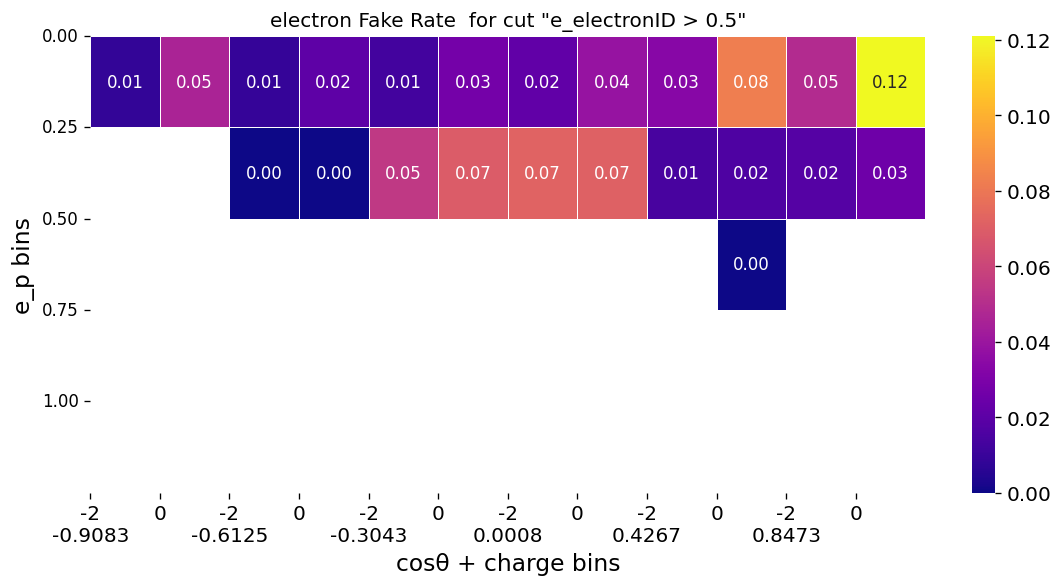

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

# === Use your input DataFrame ===
df = DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")
# df = DataFrames["All_ReverseID"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")

# === Configuration ===
pid_cut = 0.5
theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]  # descending in cos(theta)
charge_vals = [-2, 0]
p_edges = np.linspace(0.0, 1.25, 6) #[0,0.25,0.5,0.75,1,1.25]
x_bin_pairs = [(i, ch) for i in range(len(cos_edges) - 1) for ch in charge_vals]

# === Compute Fake Rate Matrix ===
fake_rate_matrix = np.full((len(p_edges) - 1, len(x_bin_pairs)), np.nan)
for i in range(len(p_edges) - 1):
    df_p = df[(df["e_p"] > p_edges[i]) & (df["e_p"] <= p_edges[i + 1])]
    for j, (cos_idx, ch_val) in enumerate(x_bin_pairs):
        cos_min = min(cos_edges[cos_idx], cos_edges[cos_idx+1])
        cos_max = max(cos_edges[cos_idx], cos_edges[cos_idx+1])
        cos_mask = (df_p["e_cos_theta"] > cos_min) & (df_p["e_cos_theta"] <= cos_max)
        charge_mask = df_p["e_charge"] < 0 if ch_val == -2 else df_p["e_charge"] >= 0
        bin_df = df_p[charge_mask & cos_mask]
        n_pass = (bin_df["e_electronID"] > pid_cut).sum()
        n_fail = (bin_df["e_electronID"] <= pid_cut).sum()
        # total = n_fail + n_pass
        if n_fail > 0:
            fake_rate_matrix[i, j] = n_pass / n_fail

# === Helper for label formatting ===
class cm:
    @staticmethod
    def compactify_numbered(x):
        return x

# === Final FakeRateTable class ===
class FakeRateTable:
    def __init__(self, values, binning, bin_variables, cut, particle_type, processing, title):
        self.values = values
        self.binning = binning
        self.bin_variables = bin_variables
        self.cut = cut
        self.particle_type = particle_type
        self.processing = processing
        self.title = title

    def compute_vmax(self, array):
        return np.nanmax(array)

    def plot(self, *args, **kw_args):
        plot_args = kw_args.get('plot_args')
        plot_percent_tuple = (100, ' [%]', 0.1) if kw_args.get('use_percent') else (1, '', 0.2)
        if kw_args.get('display_plots') is None:
            kw_args['display_plots'] = True

        label = cm.compactify_numbered(self.processing)
        if kw_args.get('label'):
            label = kw_args.get('label')

        object_name = self.title.replace('_', ' ')
        plot_title = f'{self.particle_type} {object_name} {plot_percent_tuple[1]} for cut "{self.cut}"'

        fig = kw_args.get('fig')
        ax = kw_args.get('ax')
        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=120)

        if len(self.values.shape) != 2:
            raise ValueError("Only 2D plotting is supported.")

        # Annotations WITHOUT uncertainties
        annot_labels = np.asarray([
            fr'{value*plot_percent_tuple[0]:{plot_percent_tuple[2]}f}'
            for value in self.values.flatten()
        ]).reshape(self.values.shape)

        if plot_args is None:
            plot_args = {
                'linewidths': .5,
                'fmt': '',
                'cbar_kws': {'fraction': .05},
                'vmin': 0,
                'vmax': self.compute_vmax(self.values) * plot_percent_tuple[0],
                'cmap': 'plasma'
            }

        sns.heatmap(self.values * plot_percent_tuple[0], annot=annot_labels, ax=ax, **plot_args)

        # X-axis: two-line labels
        xtick_labels = []
        for idx, (cos_idx, ch) in enumerate(x_bin_pairs):
            cos_val = cos_edges[cos_idx]
            if ch == -2:
                xtick_labels.append(f"{ch}\n{cos_val:.4f}")
            else:
                xtick_labels.append(f"{ch}\n")
        ax.set_xticks(np.arange(len(xtick_labels)))
        ax.set_xticklabels(xtick_labels, rotation=0)

        # Y-axis: momentum bin edges
        ytick_labels = [f"{e:.2f}" for e in p_edges[:-1]]
        ax.set_yticks(np.arange(len(ytick_labels)))
        ax.set_yticklabels(ytick_labels, rotation=0, fontsize=10)

        ax.set_xlabel(f'{self.bin_variables[1]} bins', fontsize=14)
        ax.set_ylabel(f'{self.bin_variables[0]} bins', fontsize=14)
        ax.set_title(plot_title)
        fig.tight_layout()

        if kw_args.get('save_plots'):
            fig.savefig(kw_args['save_plots'])

        if kw_args.get('display_plots'):
            if not hasattr(__builtins__, '__IPYTHON__'):
                fig.show()
                input()
        else:
            plt.close()

# === Create and Plot ===
table = FakeRateTable(
    values=fake_rate_matrix,
    binning=[p_edges, cos_edges],
    bin_variables=["e_p", "cosθ + charge"],
    cut="e_electronID > 0.5",
    particle_type="electron",
    processing="proc13",
    title="Fake Rate"
)

table.plot(display_plots=True)

In [14]:
import numpy as np
import pandas as pd

# === Use your input DataFrame ===
df = DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")
# df = DataFrames["All_ReverseID"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")

# === Configuration ===
pid_cut = 0.5
theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]  # descending in cos(theta)
p_edges = np.linspace(0.0, 1.25, 6)
charge_vals = [-2, 0]  # -2 = negative, 0 = positive

# === Build flat DataFrame ===
rows = []
for i in range(len(p_edges) - 1):
    p_min = p_edges[i]
    p_max = p_edges[i + 1]
    df_p = df[(df["e_p"] > p_min) & (df["e_p"] <= p_max)]

    for j in range(len(cos_edges) - 1):
        cos_min = min(cos_edges[j], cos_edges[j+1])
        cos_max = max(cos_edges[j], cos_edges[j+1])
        cos_mask = (df_p["e_cos_theta"] > cos_min) & (df_p["e_cos_theta"] <= cos_max)

        for ch_val in charge_vals:
            if ch_val == -2:
                charge_mask = df_p["e_charge"] < 0
            else:
                charge_mask = df_p["e_charge"] >= 0

            bin_df = df_p[cos_mask & charge_mask]
            n_pass = (bin_df["e_electronID"] > pid_cut).sum()
            n_fail = (bin_df["e_electronID"] <= pid_cut).sum()
            # total = n_pass + n_fail

            fake_rate = n_pass / n_fail if n_fail > 0 else np.nan

            rows.append({
                "p_min": round(p_min, 4),
                "p_max": round(p_max, 4),
                "cosTheta_min": round(cos_min, 4),
                "cosTheta_max": round(cos_max, 4),
                "charge_min": ch_val,
                "charge_max": 0 if ch_val == -2 else 2,
                "fake_rate": fake_rate
            })

# === Final table ===
fake_rate_df = pd.DataFrame(rows)
# fake_rate_df

import pandas as pd
import numpy as np

def add_fake_rate_weights(df: pd.DataFrame,
                          fake_rate_table: pd.DataFrame,
                          p_col: str = "e_p",
                          cos_col: str = "e_cos_theta",
                          charge_col: str = "e_charge",
                          weight_col: str = "fake_weight",
                          fillna_value: float = 1.0) -> pd.DataFrame:
    """
    Assigns fake rate weights to a dataframe using a bin-by-bin match with a fake rate lookup table.

    Args:
        df (pd.DataFrame): Input DataFrame to be weighted.
        fake_rate_table (pd.DataFrame): Table of fake rates with bin edges and fake_rate column.
        p_col (str): Column in df for particle momentum.
        cos_col (str): Column in df for cos(theta).
        charge_col (str): Column in df for particle charge.
        weight_col (str): Name of the output weight column.
        fillna_value (float): Value to fill for unmatched entries (default: 1.0).
        epsilon (float): Small value to loosen bin edge comparisons (default: 1e-8).

    Returns:
        pd.DataFrame: The input DataFrame with an additional `fake_weight` column.
    """
    if weight_col not in df.columns:
        df[weight_col] = np.nan
    else:
        df.loc[:, weight_col] = np.nan

    for _, row in fake_rate_table.iterrows():
        p_mask = (df[p_col] > row["p_min"]) & (df[p_col] <= row["p_max"])
        cos_mask = (df[cos_col] > row["cosTheta_min"]) & (df[cos_col] <= row["cosTheta_max"])

        if row["charge_min"] == -2:
            charge_mask = df[charge_col] < 0
        else:
            charge_mask = df[charge_col] >= 0

        total_mask = p_mask & cos_mask & charge_mask
        df.loc[total_mask, weight_col] = row["fake_rate"]

    df[weight_col] = df[weight_col].fillna(fillna_value)
    return df

In [15]:
# Input:
# - df: any DataFrame to apply weights to (signal, background, etc.)
# - fake_rate_df: already built using your code

DataFrames["All"] = add_fake_rate_weights(DataFrames["All"], fake_rate_df)
DataFrames["Signal_ReverseID"] = add_fake_rate_weights(DataFrames["Signal_ReverseID"], fake_rate_df)
DataFrames["All_ReverseID"] = add_fake_rate_weights(DataFrames["All_ReverseID"], fake_rate_df)
DataFrames["Data_ReverseID"] = add_fake_rate_weights(DataFrames["Data_ReverseID"], fake_rate_df)
# DataFrames["All_ReverseID_WCh"] = add_fake_rate_weights(DataFrames["All_ReverseID_WCh"], fake_rate_df)
# DataFrames["Data_ReverseID_WCh"] = add_fake_rate_weights(DataFrames["Data_ReverseID_WCh"], fake_rate_df)

# Optionally check result
# DataFrames["All_ReverseID"][["e_p", "e_cos_theta", "e_charge", "e_electronID", "fake_weight"]].head()

## Kinematic Weight

Fake + Kinematic Reweighting

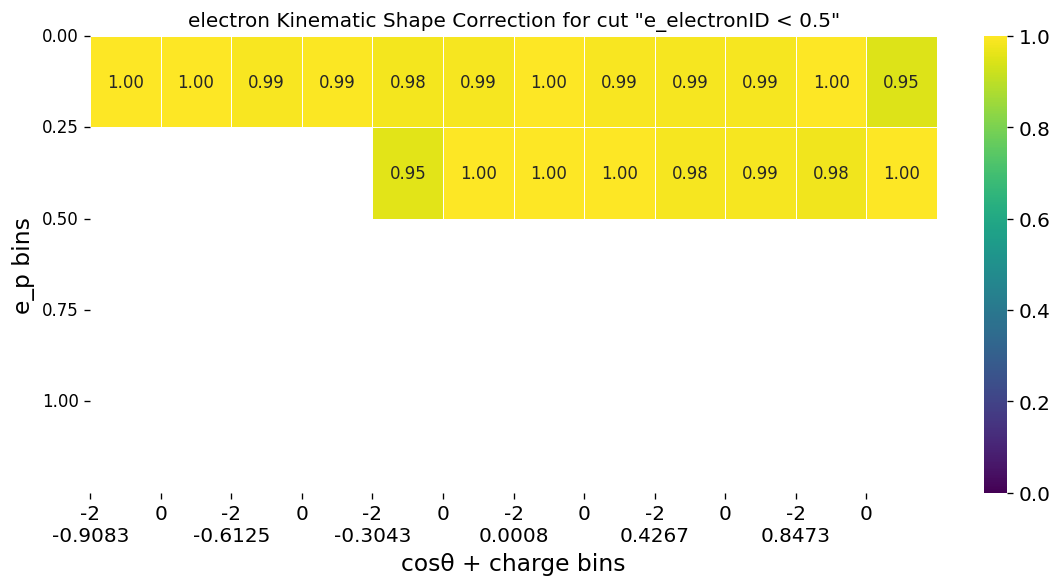

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Source and target setup ===
df_target = DataFrames["All"].query("abs(Ds_mcPDG)==413")
df_source = DataFrames["All_ReverseID"].query("(abs(Ds_mcPDG)==413) and (e_electronID < 0.5)")
# df_target = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
# df_source = DataFrames["All_ReverseID"].query("(Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15) and (e_electronID < 0.5)")

# === Binning setup ===
theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]
charge_vals = [-2, 0]
p_edges = np.linspace(0.0, 1.25, 6)
x_bin_pairs = [(i, ch) for i in range(len(cos_edges) - 1) for ch in charge_vals]

shape_matrix = np.full((len(p_edges) - 1, len(x_bin_pairs)), np.nan)
epsilon = 1e-6

for i in range(len(p_edges) - 1):
    df_p_target = df_target[(df_target["e_p"] > p_edges[i]) & (df_target["e_p"] <= p_edges[i + 1])]
    df_p_source = df_source[(df_source["e_p"] > p_edges[i]) & (df_source["e_p"] <= p_edges[i + 1])]
    
    for j, (cos_idx, ch_val) in enumerate(x_bin_pairs):
        cos_min = min(cos_edges[cos_idx], cos_edges[cos_idx+1])
        cos_max = max(cos_edges[cos_idx], cos_edges[cos_idx+1])
        
        target_mask = (
            (df_p_target["e_cos_theta"] > cos_min) &
            (df_p_target["e_cos_theta"] <= cos_max) &
            ((df_p_target["e_charge"] < 0) if ch_val == -2 else (df_p_target["e_charge"] >= 0))
        )
        
        source_mask = (
            (df_p_source["e_cos_theta"] > cos_min) &
            (df_p_source["e_cos_theta"] <= cos_max) &
            ((df_p_source["e_charge"] < 0) if ch_val == -2 else (df_p_source["e_charge"] >= 0))
        )
        
        n_target = target_mask.sum()
        n_source = df_p_source[source_mask]["fake_weight"].sum()

        if n_source > 0:
            shape_matrix[i, j] = (n_target + epsilon) / (n_source + epsilon)

# === Visualization wrapper ===
class ShapeReweightTable:
    def __init__(self, values, binning, bin_variables, cut, particle_type, processing, title):
        self.values = values
        self.binning = binning
        self.bin_variables = bin_variables
        self.cut = cut
        self.particle_type = particle_type
        self.processing = processing
        self.title = title

    def compute_vmax(self, array):
        return np.nanmax(array)

    def plot(self, display_plots=True, use_percent=False, save_plots=None, label=None, fig=None, ax=None, plot_args=None):
        plot_percent_tuple = (100, ' [%]', 0.1) if use_percent else (1, '', 0.2)

        if fig is None or ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=120)

        annot_labels = np.asarray([
            fr'{value*plot_percent_tuple[0]:{plot_percent_tuple[2]}f}'
            for value in self.values.flatten()
        ]).reshape(self.values.shape)

        if plot_args is None:
            plot_args = {
                'linewidths': .5,
                'fmt': '',
                'cbar_kws': {'fraction': .05},
                'vmin': 0,
                'vmax': self.compute_vmax(self.values) * plot_percent_tuple[0],
                'cmap': 'viridis'
            }

        sns.heatmap(self.values * plot_percent_tuple[0], annot=annot_labels, ax=ax, **plot_args)

        # X-axis: two-line labels
        xtick_labels = []
        for idx, (cos_idx, ch) in enumerate(x_bin_pairs):
            cos_val = cos_edges[cos_idx]
            if ch == -2:
                xtick_labels.append(f"{ch}\n{cos_val:.4f}")
            else:
                xtick_labels.append(f"{ch}\n")
        ax.set_xticks(np.arange(len(xtick_labels)))
        ax.set_xticklabels(xtick_labels, rotation=0)

        # Y-axis: momentum bin edges
        ytick_labels = [f"{e:.2f}" for e in p_edges[:-1]]
        ax.set_yticks(np.arange(len(ytick_labels)))
        ax.set_yticklabels(ytick_labels, rotation=0, fontsize=10)

        ax.set_xlabel(f'{self.bin_variables[1]} bins', fontsize=14)
        ax.set_ylabel(f'{self.bin_variables[0]} bins', fontsize=14)
        ax.set_title(f'{self.particle_type} {self.title} for cut "{self.cut}"')
        fig.tight_layout()

        if save_plots:
            fig.savefig(save_plots)

        if display_plots:
            if not hasattr(__builtins__, '__IPYTHON__'):
                fig.show()
                input()
        else:
            plt.close()

# === Create and plot ===
table = ShapeReweightTable(
    values=shape_matrix,
    binning=[p_edges, cos_edges],
    bin_variables=["e_p", "cosθ + charge"],
    cut="e_electronID < 0.5",
    particle_type="electron",
    processing="proc13",
    title="Kinematic Shape Correction"
)

table.plot(display_plots=True)

Kinematic Reweighting Only (Shape-Only Table)

In [17]:
# === Kinematic Shape-Only Reweighting Table ===
shape_rows = []

df_target = DataFrames["All"].query("abs(Ds_mcPDG)==413")
df_source = DataFrames["All_ReverseID"].query("(abs(Ds_mcPDG)==413) and (e_electronID < 0.5)")
# df_target = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
# df_source = DataFrames["All_ReverseID"].query("(Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15) and (e_electronID < 0.5)")

theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]
p_edges = np.linspace(0.0, 1.25, 6)
charge_vals = [-2, 0]
epsilon = 1e-6

# Normalize by number of events — not weighted sums
N_target_total = len(df_target)
N_source_total = len(df_source)

for i in range(len(p_edges) - 1):
    p_min = p_edges[i]
    p_max = p_edges[i + 1]
    df_p_target = df_target[(df_target["e_p"] > p_min) & (df_target["e_p"] <= p_max)]
    df_p_source = df_source[(df_source["e_p"] > p_min) & (df_source["e_p"] <= p_max)]

    for j in range(len(cos_edges) - 1):
        cos_min = min(cos_edges[j], cos_edges[j+1])
        cos_max = max(cos_edges[j], cos_edges[j+1])

        for ch_val in charge_vals:
            if ch_val == -2:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] < 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] < 0)
            else:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] >= 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] >= 0)

            N_target_bin = target_mask.sum()
            N_source_bin = source_mask.sum()

            # Shape-only densities
            target_density = N_target_bin / N_target_total
            source_density = N_source_bin / N_source_total

            shape_rows.append({
                "p_min": round(p_min, 4),
                "p_max": round(p_max, 4),
                "cosTheta_min": round(cos_min, 4),
                "cosTheta_max": round(cos_max, 4),
                "charge_min": ch_val,
                "charge_max": 0 if ch_val == -2 else 2,
                "kin_shape_weight": (target_density + epsilon) / (source_density + epsilon)
            })

kin_shape_df = pd.DataFrame(shape_rows)

def apply_kinematic_shape_weights(df: pd.DataFrame,
                                   shape_table: pd.DataFrame,
                                   p_col: str = "e_p",
                                   cos_col: str = "e_cos_theta",
                                   charge_col: str = "e_charge",
                                   weight_col: str = "kin_shape_weight",
                                   fillna_value: float = 1.0) -> pd.DataFrame:
    if weight_col not in df.columns:
        df[weight_col] = np.nan
    else:
        df.loc[:, weight_col] = np.nan

    for _, row in shape_table.iterrows():
        p_mask = (df[p_col] > row["p_min"]) & (df[p_col] <= row["p_max"])
        cos_mask = (df[cos_col] > row["cosTheta_min"]) & (df[cos_col] <= row["cosTheta_max"])
        charge_mask = df[charge_col] < 0 if row["charge_min"] == -2 else df[charge_col] >= 0

        total_mask = p_mask & cos_mask & charge_mask
        df.loc[total_mask, weight_col] = row["kin_shape_weight"]

    df[weight_col] = df[weight_col].fillna(fillna_value)
    return df

In [18]:
# Input:
# - df: any DataFrame to apply weights to (signal, background, etc.)
# - kin_shape_df: already built using your code

DataFrames["All"] = apply_kinematic_shape_weights(DataFrames["All"], kin_shape_df)
DataFrames["Signal_ReverseID"] = apply_kinematic_shape_weights(DataFrames["Signal_ReverseID"], kin_shape_df)
DataFrames["All_ReverseID"] = apply_kinematic_shape_weights(DataFrames["All_ReverseID"], kin_shape_df)
DataFrames["Data_ReverseID"] = apply_kinematic_shape_weights(DataFrames["Data_ReverseID"], kin_shape_df)

# Optionally check result
# DataFrames["All_ReverseID"][["e_p", "e_cos_theta", "e_charge", "e_electronID", "kin_shape_weight"]].head()

Create Combined Shape Table (after applying fake weights)

In [19]:
# === Combined Reweighting Table: Shape on top of fake-weighted sample ===
combined_rows = []

df_target = DataFrames["All"].query("abs(Ds_mcPDG)==413")
df_source = DataFrames["All_ReverseID"].query("(abs(Ds_mcPDG)==413) and (e_electronID < 0.5)")
# df_target = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
# df_source = DataFrames["All_ReverseID"].query("(Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15) and (e_electronID < 0.5)")

theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]
p_edges = np.linspace(0.0, 1.25, 6)
charge_vals = [-2, 0]
epsilon = 1e-6

# Normalize based on fake-weighted total
target_total = len(df_target)
source_total = df_source["fake_weight"].sum()

for i in range(len(p_edges) - 1):
    p_min = p_edges[i]
    p_max = p_edges[i + 1]
    df_p_target = df_target[(df_target["e_p"] > p_min) & (df_target["e_p"] <= p_max)]
    df_p_source = df_source[(df_source["e_p"] > p_min) & (df_source["e_p"] <= p_max)]

    for j in range(len(cos_edges) - 1):
        cos_min = min(cos_edges[j], cos_edges[j+1])
        cos_max = max(cos_edges[j], cos_edges[j+1])

        for ch_val in charge_vals:
            if ch_val == -2:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] < 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] < 0)
            else:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] >= 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] >= 0)

            N_target_bin = target_mask.sum()
            N_source_bin = df_p_source[source_mask]["fake_weight"].sum()

            P_target = N_target_bin / target_total
            P_source = N_source_bin / source_total

            combined_rows.append({
                "p_min": round(p_min, 4),
                "p_max": round(p_max, 4),
                "cosTheta_min": round(cos_min, 4),
                "cosTheta_max": round(cos_max, 4),
                "charge_min": ch_val,
                "charge_max": 0 if ch_val == -2 else 2,
                "combined_shape_weight": (P_target + epsilon) / (P_source + epsilon)
            })

combined_shape_df = pd.DataFrame(combined_rows)

def apply_combined_shape_weight(df: pd.DataFrame,
                                 shape_table: pd.DataFrame,
                                 p_col: str = "e_p",
                                 cos_col: str = "e_cos_theta",
                                 charge_col: str = "e_charge",
                                 weight_col: str = "combined_shape_weight",
                                 fillna_value: float = 1.0) -> pd.DataFrame:
    if weight_col not in df.columns:
        df[weight_col] = np.nan
    else:
        df.loc[:, weight_col] = np.nan

    for _, row in shape_table.iterrows():
        p_mask = (df[p_col] > row["p_min"]) & (df[p_col] <= row["p_max"])
        cos_mask = (df[cos_col] > row["cosTheta_min"]) & (df[cos_col] <= row["cosTheta_max"])
        charge_mask = df[charge_col] < 0 if row["charge_min"] == -2 else df[charge_col] >= 0

        total_mask = p_mask & cos_mask & charge_mask
        df.loc[total_mask, weight_col] = row["combined_shape_weight"]

    df[weight_col] = df[weight_col].fillna(fillna_value)
    return df

In [20]:
# Input:
# - df: any DataFrame to apply weights to (signal, background, etc.)
# - combined_shape_df: already built using your code
DataFrames["All"] = apply_combined_shape_weight(DataFrames["All"], combined_shape_df)
DataFrames["Signal_ReverseID"] = apply_combined_shape_weight(DataFrames["Signal_ReverseID"], combined_shape_df)
DataFrames["All_ReverseID"] = apply_combined_shape_weight(DataFrames["All_ReverseID"], combined_shape_df)
DataFrames["Data_ReverseID"] = apply_combined_shape_weight(DataFrames["Data_ReverseID"], combined_shape_df)

# Final combined weight
DataFrames["All"]["final_combined_weight"] = (
    DataFrames["All"]["fake_weight"] *
    DataFrames["All"]["combined_shape_weight"]
)
DataFrames["Signal_ReverseID"]["final_combined_weight"] = (
    DataFrames["Signal_ReverseID"]["fake_weight"] *
    DataFrames["Signal_ReverseID"]["combined_shape_weight"]
)
DataFrames["All_ReverseID"]["final_combined_weight"] = (
    DataFrames["All_ReverseID"]["fake_weight"] *
    DataFrames["All_ReverseID"]["combined_shape_weight"]
)
DataFrames["Data_ReverseID"]["final_combined_weight"] = (
    DataFrames["Data_ReverseID"]["fake_weight"] *
    DataFrames["Data_ReverseID"]["combined_shape_weight"]
)

Build the Kinetic Yield Ratio Table

In [21]:
# === Yield-based Reweighting Table ===
yield_rows = []

df_target = DataFrames["All"].query("abs(Ds_mcPDG)==413")
df_source = DataFrames["All_ReverseID"].query("(abs(Ds_mcPDG)==413) and (e_electronID < 0.5)")
# df_target = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
# df_source = DataFrames["All_ReverseID"].query("(Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15) and (e_electronID < 0.5)")

theta_vals = [0.22, 0.56, 1.13, 1.57, 1.88, 2.23, 2.71]
cos_edges = np.round(np.cos(theta_vals), 4)[::-1]
p_edges = np.linspace(0.0, 1.25, 6)
charge_vals = [-2, 0]
epsilon = 1e-6

for i in range(len(p_edges) - 1):
    p_min = p_edges[i]
    p_max = p_edges[i + 1]
    df_p_target = df_target[(df_target["e_p"] > p_min) & (df_target["e_p"] <= p_max)]
    df_p_source = df_source[(df_source["e_p"] > p_min) & (df_source["e_p"] <= p_max)]

    for j in range(len(cos_edges) - 1):
        cos_min = min(cos_edges[j], cos_edges[j+1])
        cos_max = max(cos_edges[j], cos_edges[j+1])

        for ch_val in charge_vals:
            if ch_val == -2:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] < 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] < 0)
            else:
                target_mask = (df_p_target["e_cos_theta"] > cos_min) & (df_p_target["e_cos_theta"] <= cos_max) & (df_p_target["e_charge"] >= 0)
                source_mask = (df_p_source["e_cos_theta"] > cos_min) & (df_p_source["e_cos_theta"] <= cos_max) & (df_p_source["e_charge"] >= 0)

            N_target_bin = target_mask.sum()
            N_source_bin = source_mask.sum()

            yield_rows.append({
                "p_min": round(p_min, 4),
                "p_max": round(p_max, 4),
                "cosTheta_min": round(cos_min, 4),
                "cosTheta_max": round(cos_max, 4),
                "charge_min": ch_val,
                "charge_max": 0 if ch_val == -2 else 2,
                "pure_kin_weight": (N_target_bin + epsilon) / (N_source_bin + epsilon)
            })

pure_kin_df = pd.DataFrame(yield_rows)

def add_yield_based_kinematic_weights(df: pd.DataFrame,
                                      kin_weight_table: pd.DataFrame,
                                      p_col: str = "e_p",
                                      cos_col: str = "e_cos_theta",
                                      charge_col: str = "e_charge",
                                      weight_col: str = "pure_kin_weight",
                                      fillna_value: float = 1.0) -> pd.DataFrame:
    """
    Assigns yield-ratio-based kinematic weights to a dataframe using a bin-by-bin lookup table.

    Args:
        df (pd.DataFrame): Input DataFrame to be weighted.
        kin_weight_table (pd.DataFrame): Table of kinematic yield weights with bin edges.
        p_col (str): Column in df for particle momentum.
        cos_col (str): Column in df for cos(theta).
        charge_col (str): Column in df for particle charge.
        weight_col (str): Name of the output weight column.
        fillna_value (float): Value to fill for unmatched entries (default: 1.0).

    Returns:
        pd.DataFrame: The input DataFrame with an additional `pure_kin_weight` column.
    """
    if weight_col not in df.columns:
        df[weight_col] = np.nan
    else:
        df.loc[:, weight_col] = np.nan

    for _, row in kin_weight_table.iterrows():
        p_mask = (df[p_col] > row["p_min"]) & (df[p_col] <= row["p_max"])
        cos_mask = (df[cos_col] > row["cosTheta_min"]) & (df[cos_col] <= row["cosTheta_max"])
        charge_mask = df[charge_col] < 0 if row["charge_min"] == -2 else df[charge_col] >= 0

        total_mask = p_mask & cos_mask & charge_mask
        df.loc[total_mask, weight_col] = row["pure_kin_weight"]

    df[weight_col] = df[weight_col].fillna(fillna_value)
    return df

In [22]:
# Input:
# - df: any DataFrame to apply weights to
# - pure_kin_df: already built using yield ratio reweighting

DataFrames["All"] = add_yield_based_kinematic_weights(DataFrames["All"], pure_kin_df)
DataFrames["Signal_ReverseID"] = add_yield_based_kinematic_weights(DataFrames["Signal_ReverseID"], pure_kin_df)
DataFrames["All_ReverseID"] = add_yield_based_kinematic_weights(DataFrames["All_ReverseID"], pure_kin_df)
DataFrames["Data_ReverseID"] = add_yield_based_kinematic_weights(DataFrames["Data_ReverseID"], pure_kin_df)
# DataFrames["All_ReverseID_WCh"] = add_yield_based_kinematic_weights(DataFrames["All_ReverseID_WCh"], pure_kin_df)
# DataFrames["Data_ReverseID_WCh"] = add_yield_based_kinematic_weights(DataFrames["Data_ReverseID_WCh"], pure_kin_df)

Reweighing Comparison

In [31]:
print(len(DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")))
print(len(DataFrames["All"].query("abs(Ds_mcPDG)==413")))

119578
3144


Width Per Bin: 0.18 MeV


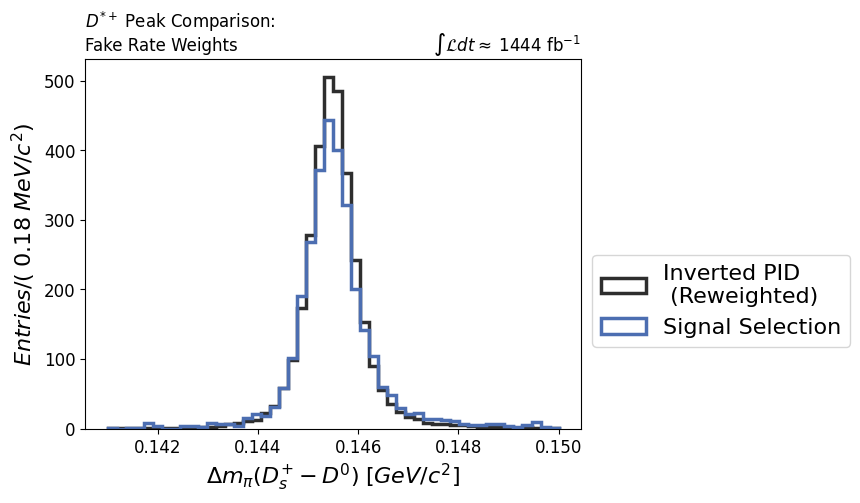

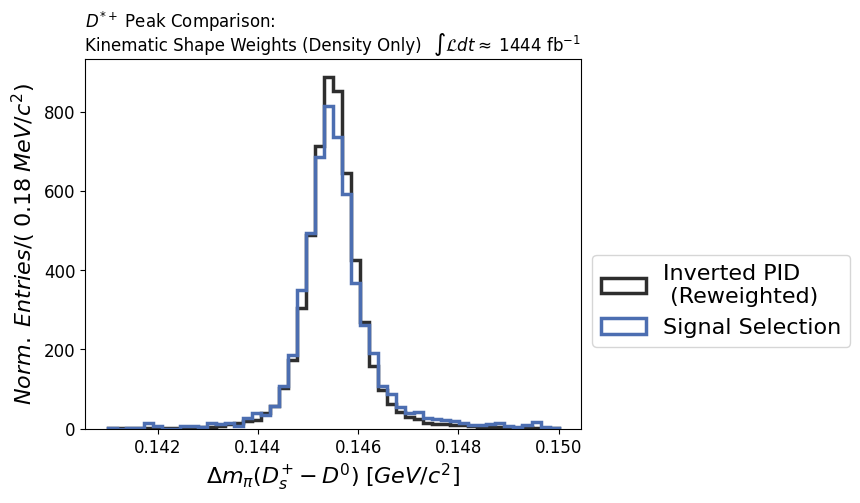

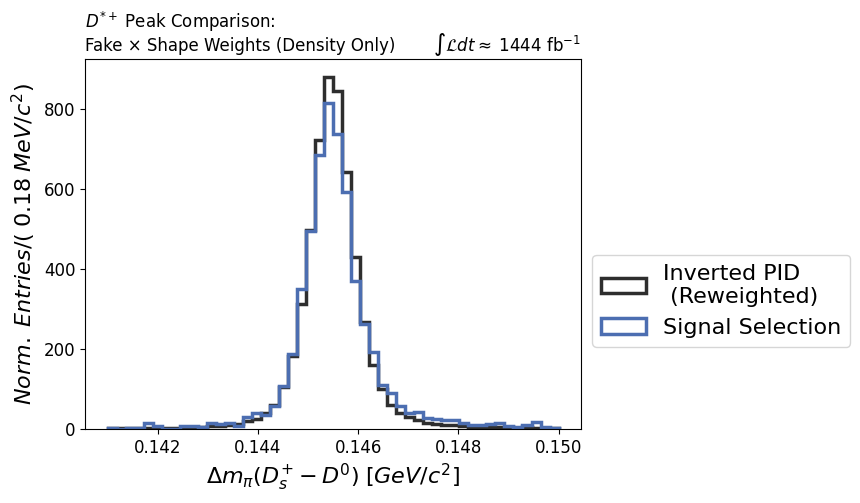

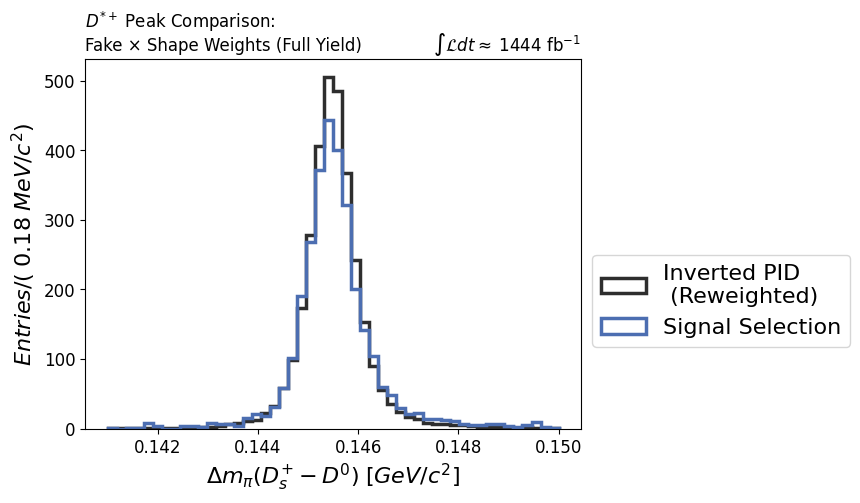

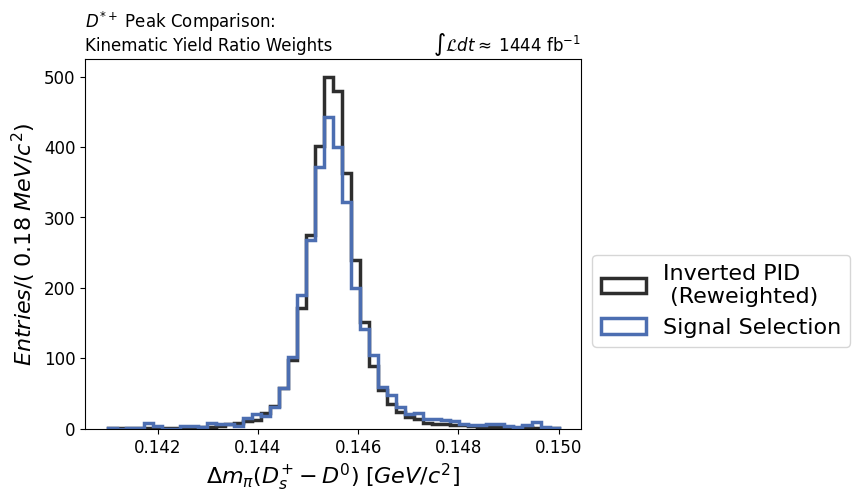

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_weight_comparisons(DataFrames):
    # plot_var = 'Ds_massDifference_0'
    plot_var = 'Ds_diff_D0pi'
    pdg_var = 'Ds_mcPDG'
    BS = -1
    Bins = 50
    Range = [0.141, 0.15]
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print("Width Per Bin: {:.2f} MeV".format(perBin))

    weight_schemes = [
        ("fake_weight", False, r"Fake Rate Weights"),
        ("kin_shape_weight", True, r"Kinematic Shape Weights (Density Only)"),
        ("combined_shape_weight", True, r"Fake × Shape Weights (Density Only)"),
        ("final_combined_weight", False, r"Fake × Shape Weights (Full Yield)"),
        ("pure_kin_weight", False, r"Kinematic Yield Ratio Weights"),
    ]

    df_ctrl = DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")
    df_sig = DataFrames["All"].query("abs(Ds_mcPDG)==413")
    # df_ctrl = DataFrames["All_ReverseID"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
    # df_sig = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")

    for weight_var, density_flag, title in weight_schemes:
        ctrl_mask = (
            (df_ctrl["Ds_BkgBDT"] >= BS) &
            # (abs(df_ctrl[pdg_var]) == 413) &
            (df_ctrl["e_electronID"] < 0.5)
        )
        sig_mask = (
            (df_sig["Ds_BkgBDT"] >= BS) &
            # (abs(df_sig[pdg_var]) == 413) &
            (df_sig["e_electronID"] > 0.5)
        )

        ctrl_vals = df_ctrl.loc[ctrl_mask, plot_var].values
        ctrl_weights = df_ctrl.loc[ctrl_mask, weight_var].values
        sig_vals = df_sig.loc[sig_mask, plot_var].values

        # === Plot ===
        plt.hist(ctrl_vals,
                 weights=ctrl_weights,
                 label="Inverted PID \n (Reweighted)",
                 color="#2E2E2E",
                 density=density_flag,
                 stacked=False,
                 bins=Bins,
                 range=Range,
                 histtype='step',
                 linewidth=2.5)

        plt.hist(sig_vals,
                 label="Signal Selection",
                 color="#4C6EB1",
                 density=density_flag,
                 stacked=False,
                 bins=Bins,
                 range=Range,
                 histtype='step',
                 linewidth=2.5)

        # === Labels ===
        plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + title, loc="left")
        # plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + title + '\n' + r"$\Delta m_{\pi}(D_s^{+} - D^{0}) \in [0.142,\; 0.15]$", loc="left")
        plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
        plt.xlabel(r'$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')

        if density_flag:
            plt.ylabel(r'$Norm. \; Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
        else:
            plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))

        plt.legend(bbox_to_anchor=(1, 0.5))
        plt.show()

plot_all_weight_comparisons(DataFrames)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_weight_comparisons(DataFrames):
    plot_vars = [
        ('e_p', r'$e^+\;$ Momentum [GeV/$c$]', [0.0, 0.8], r'[GeV/$c$]'),
        ('e_cos_theta', r'$\cos\theta(e^+)$', [-1.05, 1.05], ''),
    ]
    pdg_var = 'Ds_mcPDG'
    BS = -1
    Bins = 50

    weight_schemes = [
        (None, True, r"No Weight (Density Only)"),
        ("fake_weight", False, r"Fake Rate Weights"),
        ("kin_shape_weight", True, r"Kinematic Shape Weights (Density Only)"),
        ("combined_shape_weight", True, r"Fake × Shape Weights (Density Only)"),
        ("final_combined_weight", False, r"Fake × Shape Weights (Full Yield)"),
        ("pure_kin_weight", False, r"Kinematic Yield Ratio Weights"),
    ]

    df_ctrl = DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")
    df_sig = DataFrames["All"].query("abs(Ds_mcPDG)==413")
    df_ctrl = DataFrames["All_ReverseID"].query("Ds_diff_D0pi > 0.139 and Ds_diff_D0pi <= 0.15")
    df_sig = DataFrames["All"].query("Ds_diff_D0pi > 0.139 and Ds_diff_D0pi <= 0.15")

    for plot_var, x_label, Range, unit in plot_vars:
        bin_width = (Range[1] - Range[0]) / Bins
        print(f"Plotting: {plot_var} — Bin Width: {bin_width:.4f}")

        for weight_var, density_flag, title in weight_schemes:
            ctrl_mask = (
                (df_ctrl["Ds_BkgBDT"] >= BS) &
                # (abs(df_ctrl[pdg_var]) == 413) &
                (df_ctrl["e_electronID"] < 0.5)
            )
            sig_mask = (
                (df_sig["Ds_BkgBDT"] >= BS) &
                # (abs(df_sig[pdg_var]) == 413) & 
                (df_sig["e_electronID"] > 0.5)
            )

            ctrl_vals = df_ctrl.loc[ctrl_mask, plot_var].values
            sig_vals = df_sig.loc[sig_mask, plot_var].values

            if weight_var is None:
                ctrl_weights = None
            else:
                ctrl_weights = df_ctrl.loc[ctrl_mask, weight_var].values

            # === Plot ===
            plt.hist(ctrl_vals,
                     weights=ctrl_weights,
                     label="Inverted PID",
                     color="#2E2E2E",
                     density=density_flag,
                     bins=Bins,
                     range=Range,
                     histtype='step',
                     linewidth=2.5)

            plt.hist(sig_vals,
                     label="Signal Selection",
                     color="#4C6EB1",
                     density=density_flag,
                     bins=Bins,
                     range=Range,
                     histtype='step',
                     linewidth=2.5)

            # === Labels ===
            plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + title, loc="left")
            plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
            plt.xlabel(x_label)

            if density_flag:
                plt.ylabel(r'$Normalized\; Entries/({:.4f}\;{})$'.format(bin_width, unit))
            else:
                plt.ylabel(r'$Entries/({:.4f}\;{})$'.format(bin_width, unit))

            plt.legend()
            plt.xlim(Range)
            plt.show()

plot_all_weight_comparisons(DataFrames)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_weight_comparisons(DataFrames):
    # plot_var = 'Ds_massDifference_0'
    plot_var = 'Ds_diff_D0pi'
    pdg_var = 'Ds_mcPDG'
    BS = 0.7
    Bins = 50
    Range = [0.141, 0.15]
    edges = np.linspace(Range[0], Range[1], Bins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    perBin = ((Range[1] - Range[0]) / Bins) * 1000
    print("Width Per Bin: {:.2f} MeV".format(perBin))

    weight_schemes = [
        ("fake_weight", False, r"Fake Rate Weights"),
        ("kin_shape_weight", True, r"Kinematic Shape Weights (Density Only)"),
        ("combined_shape_weight", True, r"Fake × Shape Weights (Density Only)"),
        ("final_combined_weight", False, r"Fake × Shape Weights (Full Yield)"),
        ("pure_kin_weight", False, r"Kinematic Yield Ratio Weights"),
    ]

    # df_ctrl = DataFrames["All_ReverseID"].query("abs(Ds_mcPDG)==413")
    # df_sig = DataFrames["All"].query("abs(Ds_mcPDG)==413")
    df_ctrl = DataFrames["All_ReverseID"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")
    df_sig = DataFrames["All"].query("Ds_diff_D0pi > 0.142 and Ds_diff_D0pi <= 0.15")

    for weight_var, density_flag, title in weight_schemes:
        ctrl_mask = (
            (df_ctrl["Ds_BkgBDT"] >= BS) &
            # (abs(df_ctrl[pdg_var]) == 413) &
            (df_ctrl["e_electronID"] < 0.5)
        )
        sig_mask = (
            (df_sig["Ds_BkgBDT"] >= BS) &
            # (abs(df_sig[pdg_var]) == 413) &
            (df_sig["e_electronID"] > 0.5)
        )

        ctrl_vals = df_ctrl.loc[ctrl_mask, plot_var].values
        ctrl_weights = df_ctrl.loc[ctrl_mask, weight_var].values
        sig_vals = df_sig.loc[sig_mask, plot_var].values

        # Compute histograms
        hist_ctrl, _ = np.histogram(ctrl_vals, bins=edges, weights=ctrl_weights)
        sumw2_ctrl, _ = np.histogram(ctrl_vals, bins=edges, weights=ctrl_weights**2)
        hist_sig, _ = np.histogram(sig_vals, bins=edges)

        if density_flag:
            bin_widths = np.diff(edges)
            total_weight = np.sum(ctrl_weights)

            hist_ctrl = hist_ctrl / (total_weight * bin_widths)
            hist_sig = hist_sig / (np.sum(hist_sig) * bin_widths)
            sumw2_ctrl = sumw2_ctrl / (total_weight**2 * bin_widths**2)
            err_ctrl = np.sqrt(sumw2_ctrl)
        else:
            err_ctrl = np.sqrt(sumw2_ctrl)

        # Chi-squared per bin
        with np.errstate(divide='ignore', invalid='ignore'):
            total_err_sq = err_ctrl**2 + hist_sig
            chi2_bins = np.where(total_err_sq > 0, (hist_ctrl - hist_sig) ** 2 / total_err_sq, 0)
        chi2 = np.sum(chi2_bins)
        ndf = np.count_nonzero(total_err_sq)
        chi2_per_bin = chi2 / ndf if ndf > 0 else 0

        # === Plot ===
        plt.errorbar(bin_centers, hist_ctrl, yerr=err_ctrl, fmt='o', color="#2E2E2E",
                     label="Inverted PID\n(Reweighted)", markersize=3, capsize=2)

        plt.hist(sig_vals,
                 label="Signal Selection",
                 color="#4C6EB1",
                 density=density_flag,
                 stacked=False,
                 bins=Bins,
                 range=Range,
                 histtype='step',
                 linewidth=2.5)

        # === Labels ===
        # plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + title, loc="left")
        plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + title + '\n' + r"$\Delta m_{\pi}(D_s^{+} - D^{0}) \in [0.139,\; 0.15]$", loc="left")
        plt.title(r"$\chi^2/ndf = {:.2f}$".format(chi2_per_bin), loc="right")
        plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')

        if density_flag:
            plt.ylabel(r'$Norm. \; Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
        else:
            plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))

        plt.legend()
        plt.xlim(Range)
        plt.show()

plot_all_weight_comparisons(DataFrames)

## Add Fake Weight (data/MC Correction)

In [ ]:
# ratio_cfg = {
#     "cut": "electronID > 0.1",
#     "particle_type": "pi",
#     "data_collection": "proc13+prompt",  # Change it to full data, e.g. proc13+prompt
#     "mc_collection": "MC15ri", # Change it to full MC, e.g. MC15ri
#     "track_variables": ["p", "cosTheta", "charge"],
#     "binning": [list(np.linspace(0.0, 3.0, 11)),
#                [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563],
#                [-2, 0, 2]]
# }
# fake_rate = wm.produce_data_mc_ratio(**ratio_cfg)
# fake_rate.plot()

In [ ]:
# fake_table_pi_as_e = fake_rate.create_weights()

# fake_table_pi_as_e[["p_min","p_max","cosTheta_min","cosTheta_max","charge_min","charge_max","data_MC_ratio","threshold"]]

In [ ]:
# tables = {(11, 211): fake_table_pi_as_e}
# thresholds = {11: ('electronID', 0.1)}

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     sysvar.add_weights_to_dataframe('e', # Specify your particle prefix here, e.g. "DST_D0_K"
#                              DataFrames["All_ReverseID"],
#                              systematic='custom_PID',
#                              custom_tables=tables,
#                              generate_variations=False,
#                              custom_thresholds=thresholds)

# $D^{*+}$ Signal Selection

In [ ]:
# === Settings ===
Stacked = True
Density = False
Bins = 50
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# Variable to plot after cut
var = 'Ds_massDifference_0'

# Labels and colors
labels = [
    r'$c \bar{c}$',
    r'$u \bar{u}, \; d \bar{d}, \;s \bar{s}$',
    r'$BB$',
    r'$\tau^{+} \tau^{-}$'
]

# Apply sideband cut (outside signal region) and collect data
data = [
    DataFrames["ccbar"].query("e_electronID >= 0.5")[var],
    DataFrames["uds"].query("e_electronID >= 0.5")[var],
    DataFrames["BB"].query("e_electronID >= 0.5")[var],
    DataFrames["taupair"].query("e_electronID >= 0.5")[var],
]

# === Plot ===
# plt.figure(figsize=(8, 5))
plt.hist(data[::-1],
         label=labels[::-1],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

# Titles
# r'$\Delta m_{\pi}(D_s^{+} - D^{0}) \notin [0.144,\; 0.147] \; \mathrm{GeV}/c^{2}$'
plt.title(r'$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+}] e^{+} \nu_{e}$', loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")

# Labels
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.tight_layout()
plt.show()

Width Per Bin: 5.16 MeV


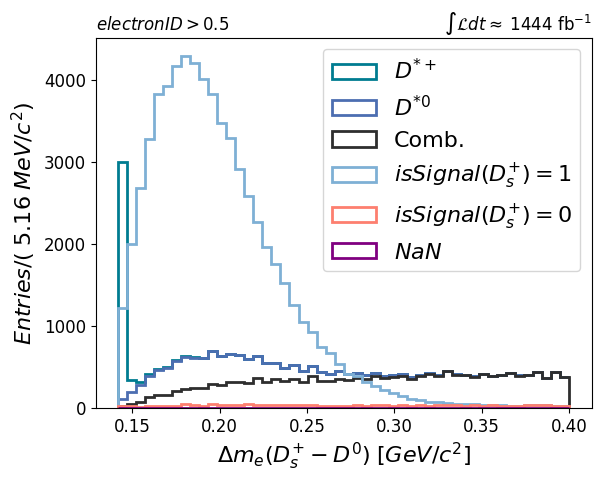

In [42]:
# === Settings ===
Stacked = True
Density = False
Bins = 50
BS = 0.7
Range = [0.142, 0.4]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# Data source and variables
df = DataFrames["All"][(DataFrames["All"]["Ds_BkgBDT"]>=BS)]
cut_var = "Ds_diff_D0pi"
plot_var = "Ds_diff_D0pi"
pdg_var = 'Ds_mcPDG'

# Sideband cut (exclude D*⁺ peak)
df_cut = df

# === Categories based on true Ds_mcPDG ===
dstar_plus = df_cut[abs(df_cut[pdg_var]) == 413][plot_var]
dstar_zero = df_cut[abs(df_cut[pdg_var]) == 423][plot_var]
other = df_cut[(abs(df_cut[pdg_var]) != 413) & (abs(df_cut[pdg_var]) != 423) & (abs(df_cut["D0_genMotherPDG"]) != 413)][plot_var]

# === Plot ===
plt.hist([other, dstar_zero, dstar_plus],
         color=["#2E2E2E", "#4C6EB1", "#007C91"],
         label=["Comb.", r"$D^{*0}$", r"$D^{*+}$"],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

label1= r'$isSignal(D_s^{+})=1$'
label2= r'$isSignal(D_s^{+})=0$'
label3= r'$NaN$'

labels=[label1,label2,label3]
colors=['#7eb0d5','#fd7f6f','purple']

data = [DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==1) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==0) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal'].isna()) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var]
       ]


plt.hist(data[::-1], color=colors[::-1], label=labels[::-1], alpha=1, range=Range, linewidth=2, stacked=Stacked, density=Density, bins=Bins, histtype='step')

# Titles and labels
plt.title(r'$electronID > 0.5$', loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.tight_layout()
plt.show()

Width Per Bin: 5.30 MeV


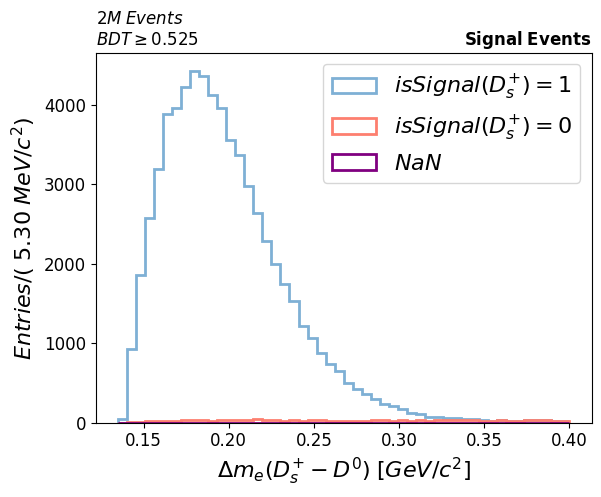

In [33]:
Bins=50
Density = False
Stacked = True
Range = [0.135,0.4]
BS = 0.7
perBin = ((Range[1] - Range[0])/Bins)*1000
var = 'Ds_diff_D0pi'
# var = 'Ds_massDifference_0'
print("Width Per Bin: {width:.2f} MeV".format(width = perBin))

label1= r'$isSignal(D_s^{+})=1$'
label2= r'$isSignal(D_s^{+})=0$'
label3= r'$NaN$'

labels=[label1,label2,label3]
colors=['#7eb0d5','#fd7f6f','purple']

data = [DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==1) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal']==0) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var],
        DataFrames["Signal"][(DataFrames["Signal"]['Ds_isSignal'].isna()) & (DataFrames["Signal"]["Ds_BkgBDT"]>=BS)][var]
       ]


plt.hist(data[::-1], color=colors[::-1], label=labels[::-1], alpha=1, range=Range, linewidth=2, stacked=Stacked, density=Density, bins=Bins, histtype='step')
# plt.axvspan(Range[0],0.16,color='gray',alpha=0.2)
# plt.axvline(0.16,ls='--',color='gray')

# Title
#---------
# Signal
# plt.title(r'$2M\;Events$', loc = "left")
plt.title(r'$2M\;Events$'+"\n"+r"$BDT \geq 0.525$", loc = "left")
plt.title(r'$\bf Signal\;Events$', loc = "right")
# # Background
# plt.title(r'$\int\mathcal{L}dt\approx\;100$ fb$^{-1}$', loc = "left")
# plt.title(r'$\bf Generic\;c\bar{c}\;Events$', loc = "right")
# Label
#---------
plt.ylabel(r'$Entries/(\; {width:.2f}\;MeV/c^2)$'.format(width = perBin))
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
# plt.yscale("log") 
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# === Settings ===
Stacked = True
Density = False
Bins = 50
BS = 0.86
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# === Peak region cut ===
peak_min, peak_max = 0.139, 0.150

# Data source and variables
df = DataFrames["All"][
    (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_diff_D0pi"] > peak_min) &
    (DataFrames["All"]["Ds_diff_D0pi"] <= peak_max)
]

plot_var = 'Ds_massDifference_0'
pdg_var = 'Ds_mcPDG'

# === Categories based on true Ds_mcPDG ===
dstar_plus = df[abs(df[pdg_var]) == 413][plot_var]
dstar_zero = df[abs(df[pdg_var]) == 423][plot_var]
other = df[(abs(df[pdg_var]) != 413) & (abs(df[pdg_var]) != 423)][plot_var]

# === Plot ===
plt.hist([other, dstar_zero, dstar_plus],
         color=["#2E2E2E", "#4C6EB1", "#007C91"],
         label=["Comb.", r"$D^{*0}$", r"$D^{*+}$"],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

# Titles and labels
plt.title(r'$0.139 < \Delta m_{\pi}(D_s^+ - D^0) \leq 0.150$', loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
plt.show()

In [ ]:
# === Settings ===
Stacked = True
Density = False
Bins = 50
BS = 0.86
Range = [0.142, 0.15]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# Data source and variables
df = DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["Ds_BkgBDT"]>=BS)]
cut_var = "Ds_diff_D0pi"
plot_var = "Ds_diff_D0pi"
pdg_var = 'Ds_mcPDG'

# Sideband cut (exclude D*⁺ peak)
df_cut = df

# === Categories based on true Ds_mcPDG ===
dstar_plus = df_cut[abs(df_cut[pdg_var]) == 413][plot_var]
dstar_zero = df_cut[abs(df_cut[pdg_var]) == 423][plot_var]
other = df_cut[(abs(df_cut[pdg_var]) != 413) & (abs(df_cut[pdg_var]) != 423)][plot_var]

# === Plot ===
plt.hist([other, dstar_zero, dstar_plus],
         color=["#2E2E2E", "#4C6EB1", "#007C91"],
         label=["Comb.", r"$D^{*0}$", r"$D^{*+}$"],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

# Titles and labels
plt.title(r'$electronID > 0.5$' + '\n' + "Inverted PID", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{\pi}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.tight_layout()
plt.show()

In [ ]:
# Define the peak region
peak_min, peak_max = 0.139, 0.150

# Apply the same BDT and peak region cut
df_peak = DataFrames["All"][
    (DataFrames["All"]["Ds_BkgBDT"] >= BS) &
    (DataFrames["All"]["Ds_diff_D0pi"] > peak_min) &
    (DataFrames["All"]["Ds_diff_D0pi"] <= peak_max)
]

# Total in this Δm_π region
N_total = len(df_peak)

# Number from D*+
N_dstar_plus = len(df_peak[abs(df_peak["Ds_mcPDG"]) == 413])

# Compute contribution
fraction_dstar_plus = N_dstar_plus / N_total if N_total > 0 else 0
print(f"D*+ fraction in [0.139, 0.150] GeV/c²: {fraction_dstar_plus:.3f}")

# Reverse PID

In [ ]:
# === Settings ===
Stacked = True
Density = False
Bins = 50
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# Cut range on 'Ds_diff_D0pi'
cut_low = 0.14543 - (3*0.00041124)
cut_high = 0.14543 + (3*0.00041124)

# Variable to plot after cut
var = 'Ds_massDifference_0'

# Labels and colors
labels = [
    r'$c \bar{c}$',
    r'$u \bar{u}, \; d \bar{d}, \;s \bar{s}$',
    r'$BB$',
    r'$\tau^{+} \tau^{-}$'
]

# Apply sideband cut (outside signal region) and collect data
# Ds_diff_D0pi <= @cut_low or Ds_diff_D0pi >= @cut_high
data = [
    DataFrames["ccbar_ReverseID"].query("e_electronID <= 0.5")[var],
    DataFrames["uds_ReverseID"].query("e_electronID <= 0.5")[var],
    DataFrames["BB_ReverseID"].query("e_electronID <= 0.5")[var],
    DataFrames["taupair_ReverseID"].query("e_electronID <= 0.5")[var],
]

# === Plot ===
# plt.figure(figsize=(8, 5))
plt.hist(data[::-1],
         label=labels[::-1],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

# Titles
plt.title(r'$D_s^{+} \rightarrow [D^{0} \rightarrow K^{-} \pi^{+}] e^{+} \nu_{e}$', loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")

# Labels
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.tight_layout()
plt.show()

In [ ]:
# === Settings ===
Stacked = True
Density = False
Bins = 50
BS = -1
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# Data source and variables
df_cut = DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"] < 0.5) & (DataFrames["All_ReverseID"]["Ds_BkgBDT"]>=BS)]
cut_var = "Ds_diff_D0pi"
plot_var = 'Ds_massDifference_0'
pdg_var = 'Ds_mcPDG'

# === Categories based on true Ds_mcPDG ===
dstar_plus = df_cut[abs(df_cut[pdg_var]) == 413][plot_var]
dstar_zero = df_cut[abs(df_cut[pdg_var]) == 423][plot_var]
other = df_cut[(abs(df_cut[pdg_var]) != 413) & (abs(df_cut[pdg_var]) != 423) & (abs(df_cut["D0_genMotherPDG"]) != 413)][plot_var]

# === Plot ===
plt.hist([other, dstar_zero, dstar_plus],
         color=["#2E2E2E", "#4C6EB1", "#007C91"],
         label=["Comb.", r"$D^{*0}$", r"$D^{*+}$"],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2)

# Titles and labels
plt.title(r'$electronID < 0.5$' + '\n' +
          r'$\Delta m_{\pi}(D_s^{+} - D^{0}) \notin [0.144,\; 0.147] \; \mathrm{GeV}/c^{2}$', loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# === Settings ===
Stacked = False
Density = True
Bins = 50
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# === Variables ===
plot_var = 'Ds_massDifference_0'
pdg_var = 'Ds_mcPDG'
cut_var = "Ds_diff_D0pi"
BS = -1

# === Control sample: reversed PID ===
df_ctrl = DataFrames["All_ReverseID"]
ctrl_mask = (
    (df_ctrl["Ds_BkgBDT"] >= BS) &
    (abs(df_ctrl[pdg_var]) == 413) &
    (df_ctrl["e_binaryPID_11_211"] < 0.5)
)
ctrl_dstar_plus = df_ctrl.loc[ctrl_mask, plot_var].to_numpy()

# === Generic MC sample ===
df_gen = DataFrames["All_ReverseID"]
gen_mask = (
    (df_gen["Ds_BkgBDT"] >= BS) &
    (df_gen["e_binaryPID_11_211"] >= 0.5) &
    (abs(df_gen[pdg_var]) == 413)
)
gen_dstar_plus = df_gen.loc[gen_mask, plot_var].to_numpy()

# === Plot ===
plt.hist([gen_dstar_plus,ctrl_dstar_plus],
         label=["Signal Selection","Inverted PID"],
         color=["#4C6EB1","#2E2E2E"],
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2.5)

plt.title(r"$D^{*+}$ Peak Comparison:", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Norm. \; Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
# plt.ylim(0, 35)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Settings ===
Stacked = False
Density = True
Bins = 50
BS = -1
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000
print("Width Per Bin: {:.2f} MeV".format(perBin))

# === Variables ===
plot_var = 'Ds_massDifference_0'
pdg_var = 'Ds_mcPDG'

# === Control sample: reversed PID (D*⁺ only) ===
df_rev = DataFrames["All_ReverseID"]
ctrl_mask = (
    (df_rev["Ds_BkgBDT"] >= BS) &
    (abs(df_rev[pdg_var]) == 413) &
    (df_rev["e_electronID"] < 0.5)
)
ctrl_dstar_plus = df_rev.loc[ctrl_mask, plot_var].values
ctrl_weights = df_rev.loc[ctrl_mask, "fake_weight"].values

# === Generic MC: signal selection (D*⁺ only, e passes PID) ===
df_gen = DataFrames["All"]
gen_mask = (
    (df_gen["e_electronID"] > 0.5) &
    (df_gen["Ds_BkgBDT"] >= BS) &
    (abs(df_gen[pdg_var]) == 413)
)
gen_dstar_plus = df_gen.loc[gen_mask, plot_var].values

# === Plot ===
plt.hist(ctrl_dstar_plus,
         weights=ctrl_weights,
         label="Inverted PID \n (Reweighted)",
         color="#2E2E2E",
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2.5)

plt.hist(gen_dstar_plus,
         label="Signal Selection",
         color="#4C6EB1",
         density=Density,
         stacked=Stacked,
         bins=Bins,
         range=Range,
         histtype='step',
         linewidth=2.5)

# === Labels ===
plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" + "Fake Rate Weights", loc="left")
plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
plt.xlabel(r'$\Delta m_{e}(D_s^{+} - D^{0})\;[GeV/c^{2}]$')
plt.ylabel(r'$Norm. \; Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
plt.legend()
plt.show()


Peaking Background Comparison

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
Stacked = False
Density = True
Bins = 50
BS = -1
signal_color = "#4C6EB1"
ctrl_color = "#2E2E2E"

# === Load variable list from DataFrames ===
all_columns = list(DataFrames["All_ReverseID"].columns)
features = [col for col in all_columns if DataFrames["All_ReverseID"][col].dtype in [np.float64, np.float32, np.int64]]

# === Range estimator ===
def get_clean_range(series, lower=1, upper=99, expand_ratio=0.05):
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if clean.empty:
        return (0, 1)
    if pd.api.types.is_bool_dtype(clean) or clean.dropna().isin([0, 1]).all():
        return (-0.5, 1.5)
    low = np.percentile(clean, lower)
    high = np.percentile(clean, upper)
    margin = (high - low) * expand_ratio
    return (low - margin, high + margin)

# === Loop over features ===
for plot_var in features:
    try:
        # === Apply control sample mask ===
        df_ctrl = DataFrames["All_ReverseID"]
        ctrl_mask = (
            (df_ctrl["Ds_BkgBDT"] >= BS) &
            (abs(df_ctrl["Ds_mcPDG"]) == 413) &
            (df_ctrl["e_electronID"] <= 0.5) & 
        )
        ctrl_dstar_plus = df_ctrl.loc[ctrl_mask, plot_var].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()

        # === Apply signal selection mask ===
        df_gen = DataFrames["All"]
        gen_mask = (
            (df_gen["Ds_BkgBDT"] >= BS) &
            (df_gen["e_electronID"] >= 0.5) &
            (abs(df_gen["Ds_mcPDG"]) == 413) & 
        )
        gen_dstar_plus = df_gen.loc[gen_mask, plot_var].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()

        # === Auto Range + bin width ===
        Range = get_clean_range(df_gen[plot_var])
        perBin = ((Range[1] - Range[0]) / Bins) * 1000  # MeV or unit-specific

        # === Plot ===
        plt.hist([ctrl_dstar_plus, gen_dstar_plus],
                 label=["Control Sample", "Signal"],
                 color=[ctrl_color, signal_color],
                 density=Density,
                 stacked=Stacked,
                 bins=Bins,
                 range=Range,
                 histtype='step',
                 linewidth=2.5)

        # === Titles and labels ===
        plt.title(r"$D^{*+}$ Peak Comparison:", loc="left")
        plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
        plt.xlabel(plot_var)
        plt.ylabel(r'$Norm \; Entries/(\;{:.2f}\;MeV)$'.format(perBin))
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"[Skipped] {plot_var}: {e}")

Control Sample Comparison

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
Stacked = False
Density = True
Bins = 50
factor = 0.25  # signal weight scale

# === Color settings ===
signal_color = "#007C91"  # Teal-blue
bkg_colors = [
    "#2E2E2E",  # Comb. (dark gray-black)
    "#D62728",  # NaN (dark red)
    "#4C6EB1",  # D*0 (muted blue)
    "#006400",  # D*+ → D0π+ (deep green)
]

# === Prompt user to select comparison mode ===
compare_mode = int(input(
    "Choose comparison mode:\n"
    "[1] Signal vs Background Categories\n"
    "[2] Signal vs All Background\n> "
).strip())

# # === Load variable list from file ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/SignalVsBkg_VariableList.txt", "r") as f:
#     features = [line.strip() for line in f if line.strip()]

# === Load variable list from DataFrames ===
all_columns = list(DataFrames["All_ReverseID"].columns)
features = [col for col in all_columns if DataFrames["All_ReverseID"][col].dtype in [np.float64, np.float32, np.int64]]

# === Clean range function ===
def get_clean_range(series, lower=1, upper=99, expand_ratio=0.05):
    """Compute a robust plotting range by trimming outliers. Handles booleans."""
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()

    if clean.empty:
        return (0, 1)

    # If boolean or only 0/1 values
    if pd.api.types.is_bool_dtype(clean) or clean.dropna().isin([0, 1]).all():
        return (-0.5, 1.5)

    # Else treat as numeric
    low = np.percentile(clean, lower)
    high = np.percentile(clean, upper)
    margin = (high - low) * expand_ratio
    return (low - margin, high + margin)

# === Main plotting loop ===
for i in features:
    # === Real signal selection
    signal_df = DataFrames["Signal_ReverseID"][(DataFrames["Signal_ReverseID"]["e_electronID"] <= 0.5)]
    signal_df = signal_df[signal_df["Ds_ifNANgiveX_isSignal_5"] == 1]
    signal_values = signal_df[i]
    signal_weights = factor * np.ones_like(signal_values)

    # === Histogram range
    Range = get_clean_range(DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"] <= 0.5)][i], upper=99)

    if compare_mode == 1:
        # === Signal vs individual background types
        labels = [
            r'$Comb.$',
            r'$NaN$',
            r'$D^{*0}$',
            r'$D^{*+} \rightarrow D^{0} \pi^{+}$',
        ]

        df_all = DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"] <= 0.5)]
        data = [
            df_all[(~df_all["Ds_mcPDG"].isna()) & (abs(df_all["Ds_mcPDG"]) != 413) & (abs(df_all["Ds_mcPDG"]) != 423)][i],
            df_all[df_all["Ds_mcPDG"].isna()][i],
            df_all[abs(df_all["Ds_mcPDG"]) == 423][i],
            df_all[abs(df_all["Ds_mcPDG"]) == 413][i],
        ]

        # Plot signal (solid line)
        plt.hist(signal_values, label="Signal", histtype='step',
                 density=Density, bins=Bins, range=Range,
                 weights=signal_weights, color=signal_color,
                 linewidth=2)

        # Plot background categories
        plt.hist(data, color=bkg_colors, label=labels, density=Density,
                 stacked=Stacked, bins=Bins, histtype='step',
                 linewidth=2, range=Range)

    else:
        # === Signal vs total background
        labels = [r'$Background$', r'$True\;Signal$']
        colors = ["#4C6EB1", "#007C91"]

        data = [
            DataFrames["All_ReverseID"][(DataFrames["All_ReverseID"]["e_electronID"] <= 0.5)][i],
            signal_values,
        ]

        plt.hist(data, color=colors, label=labels, density=Density,
                 stacked=Stacked, bins=Bins, histtype='step',
                 linewidth=2, range=Range)

    # === Finalize plot
    plt.xlabel(i)
    plt.ylabel("Normalized Entries" if Density else "Entries")
    plt.legend()
    plt.show()

# Regions

Region Comparison for all Variable

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # === Settings ===
# Stacked = False
# Density = True
# Bins = 50
# BS = -1
# signal_color = "#4C6EB1"
# ctrl_color = "#2E2E2E"

# # === Load variable list from DataFrames ===
# all_columns = list(DataFrames["Signal"].columns)
# features = [col for col in all_columns if DataFrames["Signal"][col].dtype in [np.float64, np.float32, np.int64]]

# # === Range estimator ===
# def get_clean_range(series, lower=1, upper=99, expand_ratio=0.05):
#     clean = series.replace([np.inf, -np.inf], np.nan).dropna()
#     if clean.empty:
#         return (0, 1)
#     if pd.api.types.is_bool_dtype(clean) or clean.dropna().isin([0, 1]).all():
#         return (-0.5, 1.5)
#     low = np.percentile(clean, lower)
#     high = np.percentile(clean, upper)
#     margin = (high - low) * expand_ratio
#     return (low - margin, high + margin)

# # === Loop over features ===
# for plot_var in features:
#     try:
#         # === Apply control sample mask ===
#         df_ctrl = DataFrames["Signal"]
#         ctrl_mask = (
#             (df_ctrl["Ds_BkgBDT"] >= BS) &
#             (abs(df_ctrl["Ds_isSignal"]) == 1) &
#             (df_ctrl["e_electronID"] < 0.9)
#         )
#         ctrl_dstar_plus = df_ctrl.loc[ctrl_mask, plot_var].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()

#         # === Apply signal selection mask ===
#         df_gen = DataFrames["Signal"]
#         gen_mask = (
#             (df_gen["Ds_BkgBDT"] >= BS) &
#             (df_gen["e_electronID"] >= 0.9) &
#             (abs(df_gen["Ds_isSignal"]) == 1)
#         )
#         gen_dstar_plus = df_gen.loc[gen_mask, plot_var].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()

#         # === Auto Range + bin width ===
#         Range = get_clean_range(df_gen[plot_var])
#         perBin = ((Range[1] - Range[0]) / Bins) * 1000  # MeV or unit-specific

#         # === Plot ===
#         plt.hist([ctrl_dstar_plus, gen_dstar_plus],
#                  label=["Low", "High"],
#                  color=[ctrl_color, signal_color],
#                  density=Density,
#                  stacked=Stacked,
#                  bins=Bins,
#                  range=Range,
#                  histtype='step',
#                  linewidth=2.5)

#         # === Titles and labels ===
#         plt.title(r"$D^{*+}$ Peak Comparison:" + "\n" +
#                   r'$\Delta m_{\pi}(D_s^{+} - D^{0}) \notin [0.144,\; 0.147] \; \mathrm{GeV}/c^{2}$', loc="left")
#         plt.title(r'$\int\mathcal{L}dt\approx\;1444$ fb$^{-1}$', loc="right")
#         plt.xlabel(plot_var)
#         plt.ylabel(r'$Norm \; Entries/(\;{:.2f}\;MeV)$'.format(perBin))
#         plt.legend()
#         plt.show()

#     except Exception as e:
#         print(f"[Skipped] {plot_var}: {e}")

# data/MC Comparison

Check for data/MC agreement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Settings ===
Bins = 50
Range = None
Density = False
lum_data = 364.093   # fb⁻¹
lum_MC = 1443.999    # fb⁻¹
scale_factor = lum_data / lum_MC
exclude_columns = ["__eventType__"]
figsize = (6, 6)
cut_eID_max = 0.5  # Tight reversed PID
pdg_var = "Ds_mcPDG"

# === DataFrames ===
df_mc_base = DataFrames["All_ReverseID"]
df_data_base = DataFrames["Data_ReverseID"]

# === Apply reversed PID cut
df_mc_all = df_mc_base[df_mc_base["e_electronID"] < cut_eID_max]
df_data = df_data_base[df_data_base["e_electronID"] < cut_eID_max]

# === Truth-split MC
df_mc_other = df_mc_all[(abs(df_mc_all[pdg_var]) != 413) & (abs(df_mc_all[pdg_var]) != 423)]
df_mc_dstar0 = df_mc_all[abs(df_mc_all[pdg_var]) == 423]
df_mc_dstarp = df_mc_all[abs(df_mc_all[pdg_var]) == 413]

mc_categories = [
    ("Other", df_mc_other, "#2E2E2E"),
    (r"$D^{*0}$", df_mc_dstar0, "#4C6EB1"),
    (r"$D^{*+}$", df_mc_dstarp, "#007C91"),
]

# === Optional range overrides
xrange_override = {
    "e_p": (0, 0.8),
    "pi_p": (0, 1.0),
    "K_p": (0.1, 1.0),
}

# === Variables grouped and ordered
features = [
    # Electron
    "e_cos_theta", "e_dr", "e_dz",
    # Kaon
    "K_dr",
    # Pion
    "pi_dr",
    # D0
    "D0_significanceOfDistance","Ds_FakeD0BDT",
    # Ds
    "Ds_InvMLambda", "Ds_chiProb",
    "Ds_psi","Ds_daughterMotherDiffOf_0_flightDistance", "Ds_distance", "Ds_flightDistance","Ds_Ds_starminusDs_M_Correction"
]

# === Loop over variables
for col in features:
    if col in exclude_columns:
        continue
    if col not in df_data.columns:
        print(f"Skipping missing variable: {col}")
        continue
    if not all(col in df_cat.columns for _, df_cat, _ in mc_categories):
        print(f"Skipping variable due to missing MC category: {col}")
        continue

    vals_data = df_data[col].replace([np.inf, -np.inf], np.nan).dropna()
    mc_vals_list = [df_cat[col].replace([np.inf, -np.inf], np.nan).dropna() for _, df_cat, _ in mc_categories]
    if len(vals_data) == 0 or all(len(v) == 0 for v in mc_vals_list):
        continue

    # Determine range
    if col in xrange_override:
        low, high = xrange_override[col]
    elif vals_data.dropna().isin([0, 1]).all() and all(vals.dropna().isin([0, 1]).all() for vals in mc_vals_list):
        low, high = -0.5, 1.5
    else:
        low = min(np.percentile(vals_data, 1), *(np.percentile(vals, 1) for vals in mc_vals_list))
        high = max(np.percentile(vals_data, 99), *(np.percentile(vals, 99) for vals in mc_vals_list))
    if low == high:
        continue

    # Binning
    edges = np.linspace(low, high, Bins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    perBin = (edges[1] - edges[0]) * 1000  # MeV

    # Data histogram
    hist_data, _ = np.histogram(vals_data, bins=edges, density=Density)
    err_data = np.sqrt(hist_data)

    # MC histograms
    hist_mc_cats = [np.histogram(vals, bins=edges, density=Density)[0] for vals in mc_vals_list]
    hist_mc_raw = sum(hist_mc_cats)
    hist_mc = scale_factor * hist_mc_raw
    err_mc = scale_factor * np.sqrt(hist_mc_raw)

    # Ratio and error
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = hist_data / hist_mc
        ratio[np.isnan(ratio)] = 0
        ratio[np.isinf(ratio)] = 0
        err_ratio = ratio * np.sqrt(
            (err_data / np.maximum(hist_data, 1e-10))**2 +
            (err_mc / np.maximum(hist_mc, 1e-10))**2
        )
        err_ratio[np.isnan(err_ratio)] = 0
        err_ratio[np.isinf(err_ratio)] = 0

    # === Plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.hist(mc_vals_list,
             bins=edges,
             stacked=True,
             histtype='step',
             linewidth=2,
             color=[c for _, _, c in mc_categories],
             label=[n for n, _, _ in mc_categories],
             density=Density,
             weights=[np.full(len(v), scale_factor) for v in mc_vals_list])

    ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o',
                 color='black', markersize=3, label="Data",
                 capsize=1, elinewidth=1)

    ax1.set_ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
    ax1.set_xlim([low, high])
    ax1.set_title(f"{col} — Data vs MC (Reversed eID < {cut_eID_max})", loc="left")
    ax1.legend(loc="upper right", fontsize=10)

    ax2.axhline(1.0, color='black', lw=1)
    ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
    ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
    ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o',
                 color='black', markersize=3)
    ax2.set_ylabel("Data / MC")
    ax2.set_xlabel(col)
    ax2.set_xlim([low, high])
    ax2.set_ylim(0.5, 1.5)

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
Stacked = True
Density = False
Bins = 50
Range = [0.0, 0.25]
perBin = ((Range[1] - Range[0]) / Bins) * 1000  # MeV
print("Width Per Bin: {:.2f} MeV".format(perBin))

plot_var = 'Ds_massDifference_0'
lum_data = 364.093   # fb⁻¹
lum_MC = 1443.999    # fb⁻¹
scale_factor = lum_data / lum_MC
figsize = (7, 7)

# === DataFrames before BDT ===
df_mc = DataFrames["All_ReverseID"][DataFrames["All_ReverseID"]["e_electronID"]<=0.5]
df_data = DataFrames["Data_ReverseID"][DataFrames["Data_ReverseID"]["e_electronID"]<=0.5]

# === Apply truth category separation for MC ===
pdg_var = "Ds_mcPDG"
df_mc_other = df_mc[(abs(df_mc[pdg_var]) != 413) & (abs(df_mc[pdg_var]) != 423)]
df_mc_dstar0 = df_mc[abs(df_mc[pdg_var]) == 423]
df_mc_dstarp = df_mc[abs(df_mc[pdg_var]) == 413]

mc_categories_ordered = [
    ("Other", df_mc_other),
    (r"$D^{*0}$", df_mc_dstar0),
    (r"$D^{*+}$", df_mc_dstarp),
]
mc_colors_ordered = [
    "#2E2E2E", "#4C6EB1", "#007C91"
]

# === Clean values ===
edges = np.linspace(Range[0], Range[1], Bins + 1)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

data_vals = df_data[plot_var].replace([np.inf, -np.inf], np.nan).dropna()
hist_data, _ = np.histogram(data_vals, bins=edges)
err_data = np.sqrt(hist_data)

mc_vals_list = []
for _, df_cat in mc_categories_ordered:
    vals = df_cat[plot_var].replace([np.inf, -np.inf], np.nan).dropna()
    mc_vals_list.append(vals)

mc_all_vals = np.concatenate(mc_vals_list)
hist_mc_raw, _ = np.histogram(mc_all_vals, bins=edges)
hist_mc = scale_factor * hist_mc_raw
err_mc = scale_factor * np.sqrt(hist_mc_raw)

# === Ratio calculation
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = hist_data / hist_mc
    ratio[np.isnan(ratio)] = 0
    ratio[np.isinf(ratio)] = 0

    err_ratio = ratio * np.sqrt(
        (err_data / np.maximum(hist_data, 1e-10))**2 +
        (err_mc / np.maximum(hist_mc, 1e-10))**2
    )
    err_ratio[np.isnan(err_ratio)] = 0
    err_ratio[np.isinf(err_ratio)] = 0

# === Plotting
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize,
                               gridspec_kw={"height_ratios": [3, 1]})

# === Top panel
ax1.hist(mc_vals_list,
         bins=edges,
         histtype='step',
         stacked=Stacked,
         color=mc_colors_ordered,
         label=[name for name, _ in mc_categories_ordered],
         weights=[np.full(len(vals), scale_factor) for vals in mc_vals_list],
         linewidth=2)

ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o', color='black',
             markersize=3, label="Data", capsize=1, elinewidth=1)

# # Shaded region and line on top panel
# ax1.axvspan(Range[0], 0.2, color='gray', alpha=0.2)
# ax1.axvline(0.2, ls='--', color='gray')

ax1.set_ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
ax1.set_xlim(Range)
ax1.set_title(r"$\int\mathcal{L}dt =\;364.093$ fb$^{-1}$", loc="right")
ax1.set_title(r"$Reversed\;PID:$", loc="left")
ax1.legend(loc="upper right", fontsize=14)

# === Bottom panel
ax2.axhline(1.0, color='black', lw=1)
ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o', color='black', markersize=3)

# # Shaded region and line on bottom panel
# ax2.axvspan(Range[0], 0.2, color='gray', alpha=0.2)
# ax2.axvline(0.2, ls='--', color='gray')

ax2.set_ylabel("Data / MC")
ax2.set_xlabel(r"$\Delta m_{e}(D_s^+ - D^0)$ [GeV/$c^2$]")
ax2.set_xlim(Range)
ax2.set_ylim(0.5, 1.5)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
bdt_vars = ['Ds_FakeD0BDT', 'Ds_BkgBDT']
xlabels = {
    "Ds_FakeD0BDT": r"Fake $D^0$ BDT output",
    "Ds_BkgBDT": r"Background BDT output"
}
Range = [0.0, 1.0]
Bins = 50
perBin = ((Range[1] - Range[0]) / Bins)
print("Width Per Bin: {:.2f}".format(perBin))

lum_data = 364.093   # fb⁻¹
lum_MC = 1443.999    # fb⁻¹
scale_factor = lum_data / lum_MC
figsize = (6, 6)

# === DataFrames ===
df_mc_all = DataFrames["All_ReverseID"]
df_data = DataFrames["Data_ReverseID"]

# === Define MC truth categories
pdg_var = "Ds_mcPDG"
df_mc_other = df_mc_all[(abs(df_mc_all[pdg_var]) != 413) & (abs(df_mc_all[pdg_var]) != 423)]
df_mc_dstar0 = df_mc_all[abs(df_mc_all[pdg_var]) == 423]
df_mc_dstarp = df_mc_all[abs(df_mc_all[pdg_var]) == 413]

mc_categories_ordered = [
    ("Other", df_mc_other),
    (r"$D^{*0}$", df_mc_dstar0),
    (r"$D^{*+}$", df_mc_dstarp),
]
mc_colors_ordered = [
    "#2E2E2E", "#4C6EB1", "#007C91"
]

for plot_var in bdt_vars:
    print(f"\nPlotting variable: {plot_var}")

    # === Clean values ===
    data_vals = df_data[plot_var].replace([np.inf, -np.inf], np.nan).dropna()
    mc_vals_list = [
        df[plot_var].replace([np.inf, -np.inf], np.nan).dropna()
        for _, df in mc_categories_ordered
    ]

    # === Histogram edges and bin centers ===
    edges = np.linspace(Range[0], Range[1], Bins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    # === Bin contents ===
    hist_data, _ = np.histogram(data_vals, bins=edges)
    err_data = np.sqrt(hist_data)

    mc_all_vals = np.concatenate(mc_vals_list)
    hist_mc_raw, _ = np.histogram(mc_all_vals, bins=edges)
    hist_mc = scale_factor * hist_mc_raw
    err_mc = scale_factor * np.sqrt(hist_mc_raw)

    # === Ratio calculation (Data / MC)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = hist_data / hist_mc
        ratio[np.isnan(ratio)] = 0
        ratio[np.isinf(ratio)] = 0

        err_ratio = ratio * np.sqrt(
            (err_data / np.maximum(hist_data, 1e-10))**2 +
            (err_mc / np.maximum(hist_mc, 1e-10))**2
        )
        err_ratio[np.isnan(err_ratio)] = 0
        err_ratio[np.isinf(err_ratio)] = 0

    # === Plotting ===
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize, gridspec_kw={"height_ratios": [3, 1]})

    # === Main histogram (top panel) ===
    ax1.hist(mc_vals_list,
             bins=edges,
             histtype='step',
             stacked=True,
             color=mc_colors_ordered,
             label=[name for name, _ in mc_categories_ordered],
             weights=[np.full(len(vals), scale_factor) for vals in mc_vals_list],
             linewidth=2)

    ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o', color='black',
                 markersize=3, label="Data", capsize=1, elinewidth=1)

    ax1.set_ylabel(r'$Entries/(\;{:.2f}\;)$'.format(perBin))
    ax1.set_xlim(Range)
    ax1.set_title(r"$electron$", loc="left")
    ax1.set_title(r"$\int\mathcal{L}dt =\;364.093$ fb$^{-1}$", loc="right")
    ax1.legend(loc="upper right", fontsize=14)

    # === Ratio plot (bottom panel) ===
    ax2.axhline(1.0, color='black', lw=1)
    ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
    ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
    ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o', color='black', markersize=3)
    ax2.set_ylabel("Data / MC")
    ax2.set_xlabel(xlabels[plot_var])
    ax2.set_xlim(Range)
    ax2.set_ylim(0.5, 1.5)

    plt.show()

Compare all the variable between data and MC

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # === Settings ===
# Bins = 50
# Range = None
# Density = False
# lum_data = 364.093   # fb⁻¹
# lum_MC = 1443.999    # fb⁻¹
# scale_factor = lum_data / lum_MC
# color_mc = "#007C91"
# color_data = "#2E2E2E"
# exclude_columns = ["__eventType__"]
# figsize = (6, 6)

# # === Define cut thresholds ===
# cut_eID_max = 0.5  # Tight reversed PID

# # === DataFrames ===
# df_mc_base = DataFrames["All_ReverseID"]
# df_data_base = DataFrames["Data_ReverseID"]

# # === Apply cuts ===
# df_mc = df_mc_base[df_mc_base["e_electronID"] < cut_eID_max]
# df_data = df_data_base[df_data_base["e_electronID"] < cut_eID_max]

# # === Optional range overrides ===
# xrange_override = {
#     "e_p": (0, 0.8),
#     "pi_p": (0, 1.0),
#     "K_p": (0.1, 1.0),
# }

# # === Load variable list from file ===
# with open("/home/belle2/amubarak/Ds2D0enue_Analysis/03-Grid/SignalVsBkg_VariableList.txt", "r") as f:
#     features = [line.strip() for line in f if line.strip()]

# # === Loop through variables ===
# for col in features:
#     if col in exclude_columns:
#         continue
#     if col not in df_mc.columns or col not in df_data.columns:
#         print(f"Skipping missing variable: {col}")
#         continue

#     vals_mc = df_mc[col].replace([np.inf, -np.inf], np.nan).dropna()
#     vals_data = df_data[col].replace([np.inf, -np.inf], np.nan).dropna()
#     if len(vals_mc) == 0 or len(vals_data) == 0:
#         continue

#     if col in xrange_override:
#         low, high = xrange_override[col]
#     elif (pd.api.types.is_bool_dtype(vals_mc) or vals_mc.dropna().isin([0, 1]).all()) and \
#          (pd.api.types.is_bool_dtype(vals_data) or vals_data.dropna().isin([0, 1]).all()):
#         low, high = -0.5, 1.5
#     else:
#         low = min(np.percentile(vals_mc, 1), np.percentile(vals_data, 1))
#         high = max(np.percentile(vals_mc, 99), np.percentile(vals_data, 99))
#     if low == high:
#         continue

#     edges = np.linspace(low, high, Bins + 1)
#     bin_centers = 0.5 * (edges[:-1] + edges[1:])
#     perBin = (edges[1] - edges[0]) * 1000  # MeV

#     # === Histogram contents
#     hist_data, _ = np.histogram(vals_data, bins=edges, density=Density)
#     hist_mc_raw, _ = np.histogram(vals_mc, bins=edges, density=Density)
#     hist_mc = scale_factor * hist_mc_raw
#     err_data = np.sqrt(hist_data)
#     err_mc = scale_factor * np.sqrt(hist_mc_raw)

#     with np.errstate(divide='ignore', invalid='ignore'):
#         ratio = hist_data / hist_mc
#         ratio[np.isnan(ratio)] = 0
#         ratio[np.isinf(ratio)] = 0
#         err_ratio = ratio * np.sqrt(
#             (err_data / np.maximum(hist_data, 1e-10))**2 +
#             (err_mc / np.maximum(hist_mc, 1e-10))**2
#         )
#         err_ratio[np.isnan(err_ratio)] = 0
#         err_ratio[np.isinf(err_ratio)] = 0

#     # === Plotting
#     fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize,
#                                    gridspec_kw={"height_ratios": [3, 1]})

#     ax1.hist(vals_mc, bins=edges, histtype='step', color=color_mc,
#              linewidth=2, label="MC (Reversed PID)", density=Density,
#              weights=np.full(len(vals_mc), scale_factor))
#     ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o',
#                  color='black', markersize=3, label="Data",
#                  capsize=1, elinewidth=1)

#     ax1.set_ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
#     ax1.set_xlim([low, high])
#     ax1.set_title(f"{col} — Data vs MC (Reversed eID < {cut_eID_max})", loc="left")
#     ax1.legend(loc="upper right", fontsize=10)

#     ax2.axhline(1.0, color='black', lw=1)
#     ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
#     ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
#     ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o',
#                  color='black', markersize=3)
#     ax2.set_ylabel("Data / MC")
#     ax2.set_xlabel(col)
#     ax2.set_xlim([low, high])
#     ax2.set_ylim(0.5, 1.5)

#     plt.show()

The code block below is to check for which variable is there good data/MC agreement

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # === Settings ===
# Bins = 50
# Range = None
# Density = False
# lum_data = 364.093   # fb⁻¹
# lum_MC = 1443.999    # fb⁻¹
# scale_factor = lum_data / lum_MC
# exclude_columns = ["__eventType__"]
# figsize = (6, 6)
# cut_eID_max = 0.5  # Tight reversed PID
# pdg_var = "Ds_mcPDG"

# # === DataFrames ===
# df_mc_base = DataFrames["All_ReverseID"]
# df_data_base = DataFrames["Data_ReverseID"]

# # === Apply reversed PID cut
# df_mc_all = df_mc_base[df_mc_base["e_electronID"] < cut_eID_max]
# df_data = df_data_base[df_data_base["e_electronID"] < cut_eID_max]

# # === Truth-split MC
# df_mc_other = df_mc_all[(abs(df_mc_all[pdg_var]) != 413) & (abs(df_mc_all[pdg_var]) != 423)]
# df_mc_dstar0 = df_mc_all[abs(df_mc_all[pdg_var]) == 423]
# df_mc_dstarp = df_mc_all[abs(df_mc_all[pdg_var]) == 413]

# mc_categories = [
#     ("Other", df_mc_other, "#2E2E2E"),
#     (r"$D^{*0}$", df_mc_dstar0, "#4C6EB1"),
#     (r"$D^{*+}$", df_mc_dstarp, "#007C91"),
# ]

# # === Optional range overrides
# xrange_override = {
#     "e_p": (0, 0.8),
#     "pi_p": (0, 1.0),
#     "K_p": (0.1, 1.0),
# }

# # === Variables grouped and ordered
# features = [
#     # Electron
#     "e_cos_theta", "e_dr", "e_dz",
#     # Kaon
#     "K_dr",
#     # Pion
#     "pi_dr",
#     # D0
#     "D0_significanceOfDistance","Ds_FakeD0BDT",
#     # Ds
#     "Ds_InvMLambda", "Ds_chiProb",
#     "Ds_psi","Ds_daughterMotherDiffOf_0_flightDistance", "Ds_distance", "Ds_flightDistance","Ds_Ds_starminusDs_M_Correction"
# ]

# # === Loop over variables
# for col in features:
#     if col in exclude_columns:
#         continue
#     if col not in df_data.columns:
#         print(f"Skipping missing variable: {col}")
#         continue
#     if not all(col in df_cat.columns for _, df_cat, _ in mc_categories):
#         print(f"Skipping variable due to missing MC category: {col}")
#         continue

#     vals_data = df_data[col].replace([np.inf, -np.inf], np.nan).dropna()
#     mc_vals_list = [df_cat[col].replace([np.inf, -np.inf], np.nan).dropna() for _, df_cat, _ in mc_categories]
#     if len(vals_data) == 0 or all(len(v) == 0 for v in mc_vals_list):
#         continue

#     # # Determine range
#     # if col in xrange_override:
#     #     low, high = xrange_override[col]
#     # elif vals_data.dropna().isin([0, 1]).all() and all(vals.dropna().isin([0, 1]).all() for vals in mc_vals_list):
#     #     low, high = -0.5, 1.5
#     # else:
#     #     low = min(np.percentile(vals_data, 1), *(np.percentile(vals, 1) for vals in mc_vals_list))
#     #     high = max(np.percentile(vals_data, 99), *(np.percentile(vals, 99) for vals in mc_vals_list))
#     # if low == high:
#     #     continue

#     low = 0
#     high = 0.4

#     # Binning
#     edges = np.linspace(low, high, Bins + 1)
#     bin_centers = 0.5 * (edges[:-1] + edges[1:])
#     perBin = (edges[1] - edges[0]) * 1000  # MeV

#     # Data histogram
#     hist_data, _ = np.histogram(vals_data, bins=edges, density=Density)
#     err_data = np.sqrt(hist_data)

#     # MC histograms
#     hist_mc_cats = [np.histogram(vals, bins=edges, density=Density)[0] for vals in mc_vals_list]
#     hist_mc_raw = sum(hist_mc_cats)
#     hist_mc = scale_factor * hist_mc_raw
#     err_mc = scale_factor * np.sqrt(hist_mc_raw)

#     # Ratio and error
#     with np.errstate(divide='ignore', invalid='ignore'):
#         ratio = hist_data / hist_mc
#         ratio[np.isnan(ratio)] = 0
#         ratio[np.isinf(ratio)] = 0
#         err_ratio = ratio * np.sqrt(
#             (err_data / np.maximum(hist_data, 1e-10))**2 +
#             (err_mc / np.maximum(hist_mc, 1e-10))**2
#         )
#         err_ratio[np.isnan(err_ratio)] = 0
#         err_ratio[np.isinf(err_ratio)] = 0

#     # === Plot
#     fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize,
#                                    gridspec_kw={"height_ratios": [3, 1]})

#     ax1.hist(mc_vals_list,
#              bins=edges,
#              stacked=True,
#              histtype='step',
#              linewidth=2,
#              color=[c for _, _, c in mc_categories],
#              label=[n for n, _, _ in mc_categories],
#              density=Density,
#              weights=[np.full(len(v), scale_factor) for v in mc_vals_list])

#     ax1.errorbar(bin_centers, hist_data, yerr=err_data, fmt='o',
#                  color='black', markersize=3, label="Data",
#                  capsize=1, elinewidth=1)

#     ax1.set_ylabel(r'$Entries/(\;{:.2f}\;MeV/c^2)$'.format(perBin))
#     ax1.set_xlim([low, high])
#     ax1.set_title(f"{col} — Data vs MC (Reversed eID < {cut_eID_max})", loc="left")
#     ax1.legend(loc="upper right", fontsize=10)

#     ax2.axhline(1.0, color='black', lw=1)
#     ax2.axhline(1.1, color='gray', lw=1, ls='dashed')
#     ax2.axhline(0.9, color='gray', lw=1, ls='dashed')
#     ax2.errorbar(bin_centers, ratio, yerr=err_ratio, fmt='o',
#                  color='black', markersize=3)
#     ax2.set_ylabel("Data / MC")
#     ax2.set_xlabel(col)
#     ax2.set_xlim([low, high])
#     ax2.set_ylim(0.5, 1.5)

#     plt.show()

# Save Dataframe With Fake Rate

In [ ]:
import os
import uproot
import numpy as np  # Ensure this is available for dtype conversion

# === Define ReverseID samples ===
samples_ReverseID = ["Signal_ReverseID", "All_ReverseID", "Data_ReverseID"]

# === Output directory for BkgBDT ReverseID files ===
output_dir_ReverseID = "/group/belle/users/amubarak/03-ML/04-Reversed_PID_FakeRate/"
os.makedirs(output_dir_ReverseID, exist_ok=True)

# === Base input path for ReverseID ===
base_input_dir_ReverseID = "/group/belle/users/amubarak/02-Grid/Sample_Grid_ReverseID"
Date_ReverseID = "0626"
Attempt_ReverseID = "0"

# === Save each ReverseID DataFrame with Ds_BkgBDT ===
for s in samples_ReverseID:
    if s not in DataFrames:
        print(f"Warning: {s} not in DataFrames — skipping.")
        continue

    # Set original file name
    if s == "Signal_ReverseID":
        original_name = "Ds2D0enu-Signal_ReverseID.root"
    else:
        tag = s.replace("_ReverseID", "")
        original_name = f"Ds2D0e-Generic_Ds_{Date_ReverseID}25_{Attempt_ReverseID}_{tag}.root"

    # Build output file name with _withBkgBDT suffix
    output_name = original_name.replace(".root", "_withBkgBDT.root")
    out_path = os.path.join(output_dir_ReverseID, output_name)

    # Save DataFrame to ROOT
    with uproot.recreate(out_path) as f:
        f["Dstree"] = DataFrames[s]

    print(f"Saved: {out_path}")